In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


from joblib import Parallel, delayed

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
import numpy as np
import scipy.stats
from functools import partial
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator


def mean_confidence_interval(data, confidence=0.95):
    """ Calculate mean, lower and upper bound of confidence interval """
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def Dxy(e,y,x):
    """ Calculate Dxy """
    #return 2 * concordance_index_censored(e, y, x)[0] - 1
    return 2 * concordance_index(y, x, e) - 1


def bootstrap_dxy_inner(df):
    e, y, x = df.columns
    sample = df.sample(df.shape[0], replace=True)
    
    # calculate Dxy
    return Dxy(sample[e], sample[y], sample[x])


def bootstrap_dxy(df, n=100):
    """ Boostrap and calculate Dxy """
    # resample n times
    result = Parallel(n_jobs=-1)(delayed(bootstrap_dxy_inner)(df) for i in range(n))

    return result

def apply_stats_for_each_value(df, fmap, graph_filename, condition_names=None):
    """ Apply stats to each value in column """

    all_count = df.shape[0]
    
    dff = pd.DataFrame({'E':df['E'], 'Y':df['Y'], 'agg':df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    
    stats = dff['Y'].aggregate(['count', 'median'])
    
    dxy_bootstraped = bootstrap_dxy(dff[['E', 'Y', 'agg']])
    # confidence interval
    dxy, ci_low, ci_high =  mean_confidence_interval(dxy_bootstraped)
    
    ret = {
        'Number of patiets' : stats['count'],
        '% z całej kohorty': np.round(selected_count/all_count, 2),
        'Survival days, median' : stats['median'],
        'Survival years, median' : stats['median']/365 ,
        'Dxy': np.round(dxy, 2), 
        'Confidence interval 95% low': np.round(ci_low, 2),
        'Confidence interval 95% high': np.round(ci_high, 2),
    }
    result = pd.DataFrame(ret, index=(0,))

    groups = dff.groupby(by=['agg'])['Y'].aggregate(['count', 'median', 'min', 'max', 'std','mean'])
    
    if condition_names:
        groups.index = groups.index.map(condition_names)
    #groups.columns = ['Number of patiets', 'Survival days, median', 'min', 'max', 'std']
    
    for value in dff["agg"].unique():
        mask = (dff["agg"] == value)
        time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask], dff["Y"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label="%s (n = %d, median = %d)" % (condition_names[value], mask.sum(), dff["Y"][mask].median()))

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.savefig(graph_filename+".pdf")
    plt.show()
    plt.clf()
    return result, groups

In [2]:
DATA_PREFIX="~/secret_life_of_CVEs/data/"

In [3]:
#unique_cve_info_cvss_cwe_etc_df_filename = DATA_PREFIX + 'unique_cve_info-cvss_cwe_etc.parquet'
#cve_lifespan_language_df_filename = DATA_PREFIX + 'cve_lifespan_language_df'
#cve_lifespan_df_filename = DATA_PREFIX + 'cve_lifespan_df'

#unique_cve_info_cvss_cwe_etc_df = pd.read_parquet(unique_cve_info_cvss_cwe_etc_df_filename)

# Only main programming language is tracked (project_id, cve_id)
#cve_lifespan_df = pd.read_parquet(cve_lifespan_df_filename)
#commits_df = cve_lifespan_df.drop_duplicates().copy()
#commits_df['cve'] = commits_df['commit_cves']
#df = commits_df.merge(unique_cve_info_cvss_cwe_etc_df.drop('error', axis='columns'), on='cve')

# All programming languages are tracked (project_id, cve_id, lang_id)
#cve_lifespan_language_df = pd.read_parquet(cve_lifespan_language_df_filename)
#commits_df_languages = cve_lifespan_language_df.drop_duplicates()
#commits_df_languages['cve'] = commits_df_languages['commit_cves']
#df_languages = commits_df_languages.merge(unique_cve_info_cvss_cwe_etc_df.drop('error', axis='columns'), on='cve')
df = pd.read_parquet(DATA_PREFIX + 'cve_survival_input_most_used_language_df')
df_languages = pd.read_parquet(DATA_PREFIX + 'cve_survival_input_df')

In [4]:
df['E'] = True
df['Y']=df['cve_lifespan_commiter_time'].dt.days

df_languages['E'] = True
df_languages['Y']=df_languages['cve_lifespan_commiter_time'].dt.days

In [6]:
df.shape, df_languages.shape

((97747, 48), (287884, 48))

In [7]:
print(df['commits'].describe().to_latex( escape=False))

\begin{tabular}{lr}
\toprule
{} &       commits \\
\midrule
count &  97747.000000 \\
mean  &      5.131370 \\
std   &     29.965625 \\
min   &      1.000000 \\
25%   &      1.000000 \\
50%   &      1.000000 \\
75%   &      3.000000 \\
max   &   2349.000000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/168622293.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df['commits'].describe().to_latex( escape=False))


In [8]:
df_languages.columns

Index(['commit_cves', 'project_names', 'commits', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'variable', 'value',
       'programming_paradigm', 'Programming paradigm', 'compilation_class',
       'Compilation class', 'type_class', 'Type class', 'memory_model',
       'Memory model', 'extended_programming_paradigm',
       'Programming paradigm (extended)', 'cve', 'cvss', 'cwe', 'cvss-vector',
       'access.authentication', 'access.complexity', 'access.vector',
       'impact.availability', 'impact.confidentiality', 'impact.integrity',
       'CVSS v2.0 Ratings', 'CVSS v3.1 Ratings', 'RootFork',
       'EarliestCommitDate', 'LatestCommitDate', 'NumActiveMon', 'NumAuthors',
       'NumCore', 'CommunitySize', 'NumCommits', 'NumBlobs', 'NumFiles',
       'NumForks', 'NumStars', 'E', 'Y'],
      dtype='object')

In [9]:
def compute_with_cutoff(_df, f_map_cc, condition_names_cc, graph_filename):
    condition = (_df['Y'] >= 0) & (_df['Y'] <= 100)
    S1, S2 = apply_stats_for_each_value(_df[condition], f_map_cc, graph_filename+"_100", condition_names_cc)
    display(S1), display(S2)
    print(S1.to_latex(), S2.to_latex())

    condition = (_df['Y'] >= 0) & (_df['Y'] <= 365)
    S1, S2 = apply_stats_for_each_value(_df[condition], f_map_cc, graph_filename+"_365", condition_names_cc)
    display(S1), display(S2)
    print(S1.to_latex(), S2.to_latex())

    
    condition = (_df['Y'] >= 0) & (_df['Y'] <= 3650)
    S1, S2 = apply_stats_for_each_value(_df[condition], f_map_cc,  graph_filename+"_3650", condition_names_cc)
    display(S1), display(S2)
    print(S1.to_latex(), S2.to_latex())


    condition = (_df['Y'] > 0)
    S1, S2 = apply_stats_for_each_value(_df[condition], f_map_cc, graph_filename+"_all", condition_names_cc )
    display(S1), display(S2)
    print(S1.to_latex(), S2.to_latex())


In [10]:
import seaborn as sns

<AxesSubplot: xlabel='commits'>

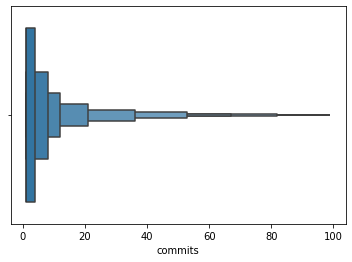

In [11]:
sns.boxenplot(data=df_languages[df_languages['commits'] < 100], x='commits', scale='exponential')

<AxesSubplot: xlabel='commits'>

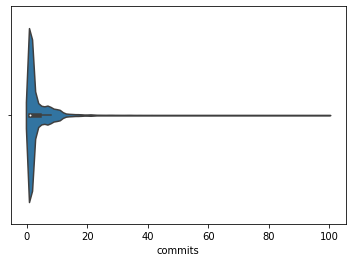

In [12]:
sns.violinplot(data=df_languages[df_languages['commits'] < 100], x='commits')

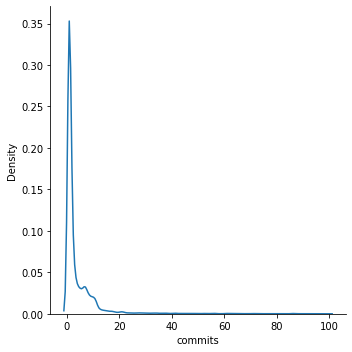

In [13]:
sns.displot(df_languages[df_languages['commits'] < 100], x='commits', kind='kde')

<AxesSubplot: xlabel='commits', ylabel='Count'>

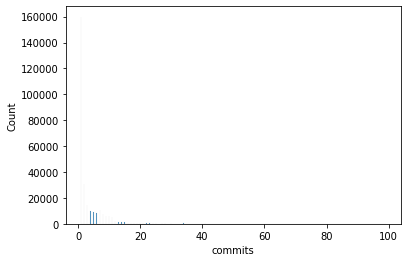

In [14]:
sns.histplot(df_languages[df_languages['commits'] < 100], x='commits')

<AxesSubplot: xlabel='commits', ylabel='Count'>

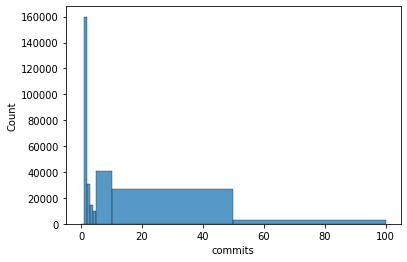

In [15]:
sns.histplot(df_languages[df_languages['commits'] >= 0], x='commits', bins=[0,1,2,3,4,5,10,50,100])

In [16]:
df_languages['commits'].describe()

count    287884.000000
mean          7.882470
std          47.519313
min           1.000000
25%           1.000000
50%           1.000000
75%           5.000000
max        2349.000000
Name: commits, dtype: float64

In [17]:
df_languages['Y'].describe()

count    287884.000000
mean        804.992702
std        1079.697016
min           0.000000
25%          49.000000
50%         368.000000
75%        1151.000000
max        8019.000000
Name: Y, dtype: float64

# Outliers projects

In [18]:
df_languages[df_languages['commits']>= 50]['project_names'].unique()

array(['NetBSD_src', 'freebsd_freebsd', 'joyent_pkgsrc-legacy',
       'python_cpython', 'gitlab.com_quicla_platform/cts',
       'openssl_openssl', 'pfsense_FreeBSD-ports',
       'git.openembedded.org_openembedded-core-contrib',
       'libressl-portable_openbsd', 'Jackeagle_kernel_msm-3.18',
       'MIPS_gcc', 'illacceptanything_illacceptanything',
       'gitlab.freedesktop.org_mesa_mesa', 'samba-team_samba',
       'NixOS_nixpkgs', 'patchew-project_next-importer-push',
       'asterisk_asterisk', 'glennrp_libpng', 'delphix_grub2',
       'android.googlesource.com_platform_libcore',
       'daedroza_aosp_development_sony8960_n', 'iqer_nginx',
       'ZIDAN44_linux-stable', 'spiderworthy_linux',
       'apple_llvm-project-v5-split', 'jayanta525_openwrt-nanopi-r4s',
       'HazouPH_android_kernel_motorola_smi', 'opencontainers_runc',
       'oss-qm_perl5', 'codeaurora-unofficial_platform-packages-apps-Mms',
       'bloomberg_chromium.bb',
       'codeaurora-unofficial_platform-framew

In [19]:
(df.groupby(by=['project_names', 'commit_cves']).count()['commits'] > 1).sum()

0

In [20]:
(df_languages.groupby(by=['project_names', 'commit_cves']).count()['commits'] > 1).sum()

49229

In [21]:
df

,commits,commit_cves,project_names,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,lang_Shell,other_languages,...,NumAuthors,NumCore,CommunitySize,NumCommits,NumBlobs,NumFiles,NumForks,NumStars,E,Y
0,1,CVE-2011-1079,0-artnoc_sm-a307fn,0,3497 days 01:37:41,2978 days 21:29:59,False,False,0.0,0.0,...,1621,655,2,5233,64451,59744,1,<NA>,True,3497
1,2,CVE-2011-1079,150balbes_Amlogic_s905-kernel,0,3069 days 09:26:00,2978 days 21:29:59,False,False,0.0,0.0,...,2498,776,60,17607,433579,136904,93,123,True,3069
2,1,CVE-2011-1079,84506232_sm-g9750_graingripper,0,3098 days 12:25:02,2978 days 21:29:59,False,False,0.0,0.0,...,1721,691,3,5964,72923,65607,2,1,True,3098
3,1,CVE-2011-1079,Ante0_CarbonKernel,0,2958 days 16:10:21,2978 days 21:29:59,False,False,0.0,0.0,...,1277,536,1,3940,66416,61845,0,<NA>,True,2958
4,2,CVE-2011-1079,Backup-Gits_Eureka-Kernel-Exynos7885-Q-R,0,3751 days 10:01:38,2978 days 21:29:59,False,False,0.0,0.0,...,1946,723,1,13242,68725,61715,0,<NA>,True,3751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97742,1,CVE-2020-24582,zulip_zulip-desktop,1,0 days 00:00:00,0 days 00:00:00,True,True,0.0,0.0,...,140,12,347,4562,7580,925,413,896,True,0
97743,2,CVE-2013-1441,zuphilip_svn.exactcode.de-exact-image,0,47 days 19:13:18,47 days 19:13:18,False,False,0.0,0.0,...,4,1,1,3937,2989,12837,0,<NA>,True,47
97744,1,CVE-2018-1000854,zweilosec_python-pearls,0,603 days 22:33:48,603 days 22:33:48,False,False,0.0,0.0,...,1,1,1,7,8,5,0,<NA>,True,603
97745,3,CVE-2020-23934,zyeinn_CVE-2020-23934,0,347 days 19:13:06,347 days 19:13:06,False,False,0.0,0.0,...,1,1,1,7,8,3,0,<NA>,True,347


# Selecting cut-off

In [22]:
df['Y'].median()

142.0

# Rozkłady liczba commitów - czas

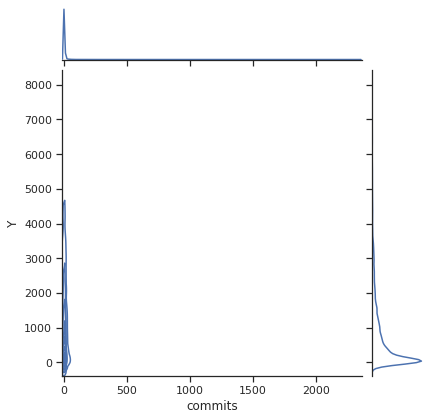

In [23]:
import seaborn as sns
sns.set_theme(style="ticks")



# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df_languages,
    x="commits", y="Y",
    kind="kde",
)

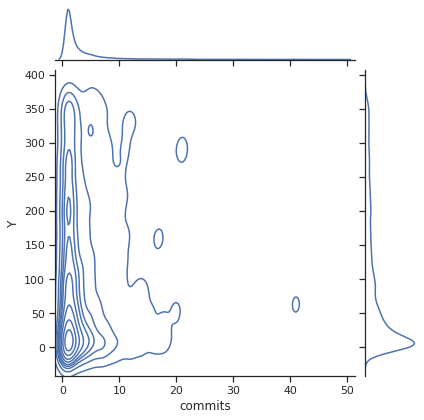

In [24]:
import seaborn as sns
sns.set_theme(style="ticks")



# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df_languages[(df_languages['Y']<365)& (df_languages['commits']<50)],
    x="commits", y="Y",
    kind="kde",
)

In [25]:
df['most_common_language'].unique()

array(['lang_C', 'lang_Python', 'lang_Clojure', 'lang_PLSQL', 'lang_Ruby',
       'lang_Assembly', 'lang_C++', 'lang_Go', 'lang_PHP', 'lang_C#',
       'lang_PowerShell', 'lang_JavaScript', 'lang_Lua', 'lang_Java',
       'lang_Scheme', 'lang_Objective-C', 'lang_Scala', 'lang_Perl',
       'lang_VBScript', 'lang_Groovy', 'lang_OCaml', 'lang_TypeScript',
       'lang_Erlang', 'lang_R', 'lang_Elixir', 'lang_Prolog', 'lang_Tcl',
       'lang_Ada', 'lang_Emacs Lisp', 'lang_Dart', 'lang_Kotlin',
       'lang_Forth', 'lang_Smalltalk', 'lang_Crystal', 'lang_Haskell',
       'lang_Swift', 'lang_Common Lisp', 'lang_Solidity', 'lang_Io'],
      dtype=object)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` 

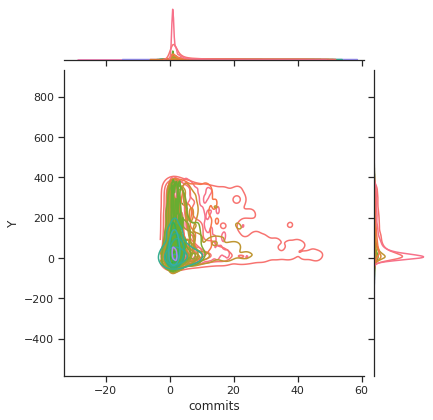

In [26]:
import seaborn as sns
sns.set_theme(style="ticks")



# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df[(df['Y']<365)& (df['commits']<50)],
    x="commits", y="Y", hue='most_common_language',
    kind="kde", legend=False
)

In [27]:
import seaborn as sns
sns.set_theme(style="ticks")



# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df[(df['Y']<365)& (df['commits']<50)&(df['most_common_language'].isin(tiobe_top_5))],
    x="commits", y="Y", hue='most_common_language',
    kind="kde", legend=False
)

NameError: name 'tiobe_top_5' is not defined

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")



# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df[(df['Y']<365)& (df['commits']<50)&(df['most_common_language'].isin(tiobe_top_5[:3]))],
    x="commits", y="Y", hue='most_common_language',
    kind="kde", legend=True
)

In [28]:
import seaborn as sns

sns.set_theme(style="darkgrid")

sns.displot(
    
    data=df_languages[(df_languages['Y']<365)& (df_languages['commits']<50)&(df_languages['most_common_language'].isin(tiobe_top_5[:3]))],
    x="commits", y="Y", col='most_common_language',
    kind="kde", legend=True
)

KeyError: 'most_common_language'

# analiza przeżycia bez czynników

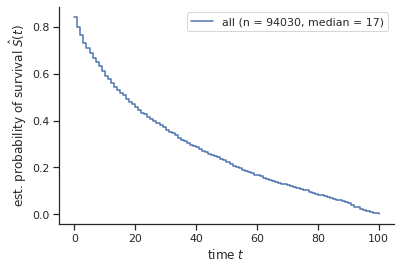

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,94030.0,1.0,17.0,0.046575,0.0,0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
all,94030,17.0,0,100,28.935872,27.691216


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            94030.0 &                1.0 &                   17.0 &                0.046575 &  0.0 &                          0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg &        &         &      &      &            &            \\
\midrule
all &  94030 &    17.0 &    0 &  100 &  28.935872 &  27.691216 \\
\bottomrule
\end{tabular}



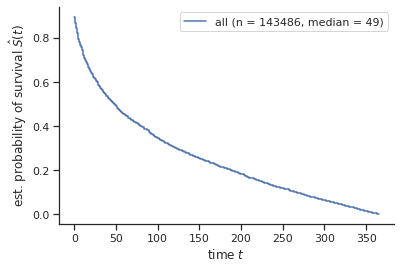

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,143486.0,1.0,49.0,0.134247,0.0,0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
all,143486,49.0,0,365,103.068081,92.666964


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           143486.0 &                1.0 &                   49.0 &                0.134247 &  0.0 &                          0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &  max &         std &       mean \\
agg &         &         &      &      &             &            \\
\midrule
all &  143486 &    49.0 &    0 &  365 &  103.068081 &  92.666964 \\
\bottomrule
\end{tabular}



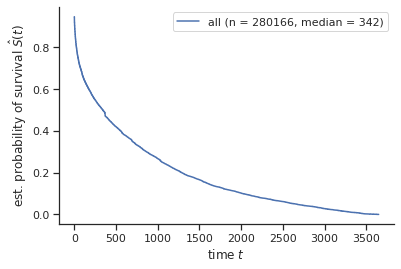

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,280166.0,1.0,342.0,0.936986,0.0,0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
all,280166,342.0,0,3649,849.702918,694.636876


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           280166.0 &                1.0 &                  342.0 &                0.936986 &  0.0 &                          0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &   max &         std &        mean \\
agg &         &         &      &       &             &             \\
\midrule
all &  280166 &   342.0 &    0 &  3649 &  849.702918 &  694.636876 \\
\bottomrule
\end{tabular}



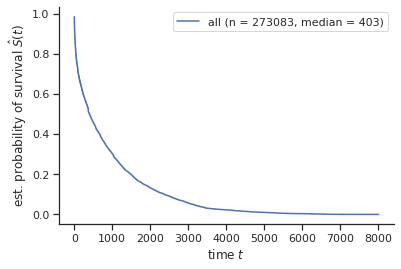

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,273083.0,1.0,403.0,1.10411,0.0,0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
all,273083,403.0,1,8019,1091.743123,848.623016


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           273083.0 &                1.0 &                  403.0 &                 1.10411 &  0.0 &                          0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &   max &          std &        mean \\
agg &         &         &      &       &              &             \\
\midrule
all &  273083 &   403.0 &    1 &  8019 &  1091.743123 &  848.623016 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [29]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


def f_map_pp(x):
    return 1
condition_names_pp = {1 : 'all'}

compute_with_cutoff(df_languages, f_map_pp, condition_names_pp, "survival_analysis")


# Languages spec

In [30]:
df_languages.groupby(by='variable').agg({'value':'sum'})

,value
variable,
lang_Ada,79174.0
lang_Assembly,1063650.0
lang_C,56970880.0
lang_C#,71384.0
lang_C++,28481025.0
lang_Clojure,2517523.0
lang_Common Lisp,134638.0
lang_Crystal,248.0
lang_Dart,113.0


,value
variable,
lang_Ada,16086.0
lang_Assembly,429971.0
lang_C,16362981.0
lang_C#,27233.0
lang_C++,9725548.0
lang_Clojure,639887.0
lang_Common Lisp,28883.0
lang_Crystal,198.0
lang_Dart,91.0


['C', 'C++', 'Java', 'Python', 'other']
[16362981.  9725548.  2953137.   593955.  9203264.]


([<matplotlib.patches.Wedge at 0x7fa2438a3eb0>,
 [Text(-1.16351268586718, 0.2936634635533347, 'C'),
  Text(0.34569175180790324, -1.1491288930019918, 'C++'),
  Text(1.1617907448727083, -0.3004035038545948, 'Java'),
  Text(1.1993109874499877, 0.0406590135361832, 'Python'),
  Text(0.8130646888018861, 0.8825677378102442, 'other')],
 [Text(-0.6787157334225217, 0.17130368707277854, '42.1%'),
  Text(0.20165352188794355, -0.6703251875844951, '25.0%'),
  Text(0.6777112678424132, -0.1752353772485136, '7.6%'),
  Text(0.6995980760124928, 0.02371775789610687, '1.5%'),
  Text(0.47428773513443356, 0.5148311803893091, '23.7%')])

(-1.2067955545272926,
 1.209787255468252,
 -1.2042259315245152,
 1.1820127040084107)

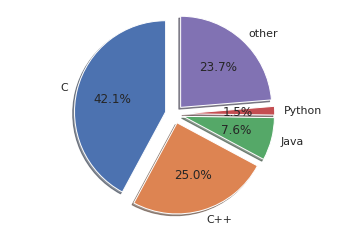

In [31]:
sel = df_languages['Y']<=365
tiobe_agg = df_languages[sel].groupby(by='variable').agg({'value':'sum'})
tiobe_agg

tiobe_top_5 = ['lang_Python', 'lang_C', 'lang_C++', 'lang_Java']

ret = tiobe_agg[tiobe_agg.index.isin(tiobe_top_5)].copy()

ret.loc['_other']=tiobe_agg[~tiobe_agg.index.isin(tiobe_top_5)].sum()

import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ret.index.map(lambda x: x.split("_")[1]).to_list()
print(labels)
sizes = ret.to_numpy().flatten()
explode = (0.1,) * len(sizes) # only "explode" the 2nd slice (i.e. 'Hogs')

print(sizes)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig("languages_sum_files.pdf")
plt.show()


In [32]:
sel = df_languages['Y']<=365
tiobe_agg =  df_languages[sel].groupby(by='variable').agg({'value':'sum'})
tiobe_agg

,value
variable,
lang_Ada,16086.0
lang_Assembly,429971.0
lang_C,16362981.0
lang_C#,27233.0
lang_C++,9725548.0
lang_Clojure,639887.0
lang_Common Lisp,28883.0
lang_Crystal,198.0
lang_Dart,91.0


In [33]:
df_languages[sel].head()

,commit_cves,project_names,commits,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,lang_Shell,other_languages,...,NumAuthors,NumCore,CommunitySize,NumCommits,NumBlobs,NumFiles,NumForks,NumStars,E,Y
36,CVE-2004-2771,bitbucket.org_cagney_netbsd,1,0,281 days 21:02:52,311 days 03:22:26,False,False,1512.0,58463.0,...,2,1,2,22,137167,144273,0,<NA>,True,281
37,CVE-2004-2771,pagodabox_nanobox-pkgsrc-lite,1,0,142 days 22:10:59,172 days 04:30:33,False,False,711.0,4862.0,...,4,2,6,24,162389,105512,5,2,True,142
38,CVE-2004-2771,bitbucket.org_cagney_netbsd,1,0,281 days 21:02:52,311 days 03:22:26,False,False,1512.0,58463.0,...,2,1,2,22,137167,144273,0,<NA>,True,281
39,CVE-2004-2771,freebsd_freebsd,4,0,26 days 22:58:10,56 days 05:17:44,True,False,4.0,28.0,...,6141,227,5791,17719890,4261584,5453699,6188,25232,True,26
40,CVE-2004-2771,pagodabox_nanobox-pkgsrc-lite,1,0,142 days 22:10:59,172 days 04:30:33,False,False,711.0,4862.0,...,4,2,6,24,162389,105512,5,2,True,142


In [34]:
tiobe_top_5 = ['lang_Python', 'lang_C', 'lang_C++', 'lang_Java']

In [35]:
ret = tiobe_agg[tiobe_agg.index.isin(tiobe_top_5)].copy()

In [36]:
ret

,value
variable,
lang_C,16362981.0
lang_C++,9725548.0
lang_Java,2953137.0
lang_Python,593955.0


In [37]:
df_languages[sel].groupby(['project_names','commit_cves']).agg({'other_languages':'min'})['other_languages'].sum()

17249288.0

In [38]:
ret.loc['_other']=tiobe_agg[~tiobe_agg.index.isin(tiobe_top_5)].sum()

In [39]:
ret.loc['_non-tiobe'] = df_languages[sel].groupby(['project_names','commit_cves']).agg({'other_languages':'min'})['other_languages'].sum()

In [40]:
#ret.loc['_shell_other'] = df[sel].agg({'lang_Shell':'sum'})['lang_Shell']

In [41]:
ret

,value
variable,
lang_C,16362981.0
lang_C++,9725548.0
lang_Java,2953137.0
lang_Python,593955.0
_other,9203264.0
_non-tiobe,17249288.0


['C', 'C++', 'Java', 'Python', 'other', 'non-tiobe']
[16362981.  9725548.  2953137.   593955.  9203264. 17249288.]


([<matplotlib.patches.Wedge at 0x7fa241840c10>,
 [Text(-0.952184828995199, 0.7303040814834487, 'C'),
  Text(-0.8300156930381923, -0.8666452269010252, 'C++'),
  Text(-0.0643586053335625, -1.1982729112850374, 'Java'),
  Text(0.17341544498430353, -1.18740350489667, 'Python'),
  Text(0.7673368977503268, -0.9226018021610976, 'other'),
  Text(0.9872517033167199, 0.6821539960289287, 'non-tiobe')],
 [Text(-0.5554411502471993, 0.4260107141986784, '29.2%'),
  Text(-0.48417582093894546, -0.505543049025598, '17.3%'),
  Text(-0.037542519777911454, -0.6989925315829384, '5.3%'),
  Text(0.10115900957417706, -0.6926520445230574, '1.1%'),
  Text(0.4476131903543572, -0.5381843845939736, '16.4%'),
  Text(0.5758968269347531, 0.39792316435020836, '30.8%')])

(-1.1874285668529703,
 1.1903512087761656,
 -1.2078918116404704,
 1.1688944108425456)

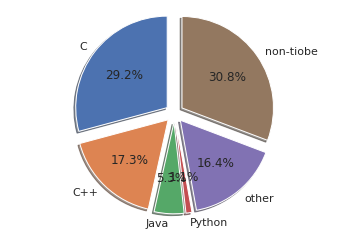

In [42]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ret.index.map(lambda x: x.split("_")[1]).to_list()
print(labels)
sizes = ret.to_numpy().flatten()
explode = (0.1,) * len(sizes) # only "explode" the 2nd slice (i.e. 'Hogs')

print(sizes)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig("languages_sum_files.pdf")
plt.show()


['C', 'C++', 'Java', 'Python', 'other', 'non-tiobe']
[24203 16028  2639 24827 75789 19509]


([<matplotlib.patches.Wedge at 0x7fa241864160>,
 [Text(-0.5397077556642743, 1.0717814788826274, 'C'),
  Text(-1.1356837926394323, 0.38758524628282087, 'C++'),
  Text(-1.1994269312788657, -0.037081484907741616, 'Java'),
  Text(-1.0165209878798889, -0.6377186536394361, 'Python'),
  Text(0.9610704940605019, -0.7185704596254309, 'other'),
  Text(0.44066544870824703, 1.1161603658591177, 'non-tiobe')],
 [Text(-0.3148295241374933, 0.6252058626815327, '14.8%'),
  Text(-0.6624822123730022, 0.22609139366497882, '9.8%'),
  Text(-0.6996657099126716, -0.021630866196182607, '1.6%'),
  Text(-0.5929705762632684, -0.37200254795633775, '15.2%'),
  Text(0.5606244548686261, -0.419166101448168, '46.5%'),
  Text(0.25705484507981075, 0.6510935467511518, '12.0%')])

(-1.2089542457456237,
 1.1890897866871892,
 -1.1675158496369282,
 1.2006576120815224)

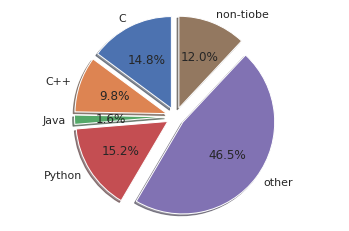

In [43]:
sel = df_languages['Y']<=365
tiobe_agg = df_languages[sel].groupby(by='variable').agg({'value':'count'})
tiobe_top_5 = ['lang_Python', 'lang_C', 'lang_C++', 'lang_Java']

ret = tiobe_agg[tiobe_agg.index.isin(tiobe_top_5)].copy()

ret.loc['_other']=tiobe_agg[~tiobe_agg.index.isin(tiobe_top_5)].sum()
ret.loc['_non-tiobe'] = ((df['Y']<=365)&(df['other_languages']>0)).sum()

import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ret.index.map(lambda x: x.split("_")[1]).to_list()
print(labels)
sizes = ret.to_numpy().flatten()
explode = (0.1,) * len(sizes) # only "explode" the 2nd slice (i.e. 'Hogs')

print(sizes)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig("languages_count_commits.pdf")
plt.show()


In [44]:
((df['Y']<=365)&(df['other_languages']>0)).sum()

19509

,most_common_language_number_of_files
most_common_language,
lang_Ada,4.0
lang_Assembly,187255.0
lang_C,15681170.0
lang_C#,23016.0
lang_C++,2476718.0
lang_Clojure,635635.0
lang_Common Lisp,50.0
lang_Crystal,13.0
lang_Dart,67.0


['C', 'C++', 'Java', 'Python', 'other']
[15681170.  2476718.  2831235.   161108.  1922148.]


([<matplotlib.patches.Wedge at 0x7fa2417c2590>,
 [Text(-1.0138976035806389, -0.6418813359597223, 'C'),
  Text(1.1934188626828794, -0.12550465406789948, 'C++'),
  Text(0.9780708249734003, 0.6952535230661204, 'Java'),
  Text(0.6224979442359717, 1.0259124277549176, 'Python'),
  Text(0.31049647735703906, 1.15913413268218, 'other')],
 [Text(-0.5914402687553726, -0.3744307793098379, '68.0%'),
  Text(0.6961610032316795, -0.07321104820627469, '10.7%'),
  Text(0.5705413145678169, 0.4055645551219036, '12.3%'),
  Text(0.36312380080431683, 0.5984489161903686, '0.7%'),
  Text(0.18112294512493946, 0.6761615773979384, '8.3%')])

(-1.19368858347144, 1.2086486035865882, -1.160994144433322, 1.2040987327467636)

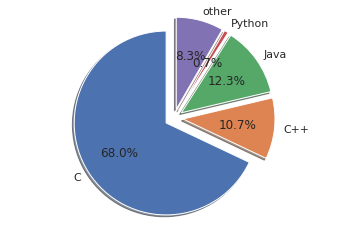

In [45]:
sel = df['Y']<=365
tiobe_agg = df[sel].groupby(by='most_common_language').agg({'most_common_language_number_of_files':'sum'})
tiobe_agg
tiobe_top_5 = ['lang_Python', 'lang_C', 'lang_C++', 'lang_Java']

ret = tiobe_agg[tiobe_agg.index.isin(tiobe_top_5)].copy()

ret.loc['_other']=tiobe_agg[~tiobe_agg.index.isin(tiobe_top_5)].sum()

import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ret.index.map(lambda x: x.split("_")[1]).to_list()
print(labels)
sizes = ret.to_numpy().flatten()
explode = (0.1,) * len(sizes) # only "explode" the 2nd slice (i.e. 'Hogs')

print(sizes)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig("languages_count_commits.pdf")
plt.show()


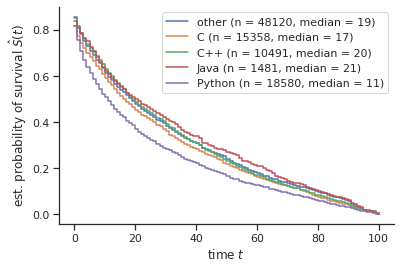

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,94030.0,1.0,17.0,0.046575,0.05,0.05,0.05


,count,median,min,max,std,mean
agg,,,,,,
Python,18580,11.0,0,100,26.854546,22.613617
C,15358,17.0,0,100,28.672568,27.317489
C++,10491,20.0,0,100,28.629498,29.130874
Java,1481,21.0,0,100,30.378659,31.035787
other,48120,19.0,0,100,29.574992,29.354239


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            94030.0 &                1.0 &                   17.0 &                0.046575 &  0.05 &                         0.05 &                          0.05 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg    &        &         &      &      &            &            \\
\midrule
Python &  18580 &    11.0 &    0 &  100 &  26.854546 &  22.613617 \\
C      &  15358 &    17.0 &    0 &  100 &  28.672568 &  27.317489 \\
C++    &  10491 &    20.0 &    0 &  100 &  28.629498 &  29.130874 \\
Java   &   1481 &    21.0 &    0 &  100 &  30.378659 &  31.035787 \\
other  &  48120 &    19.0 &    0 &  100 &  29.574992 &  29.354239 \\
\bottomrule
\end{tabular}



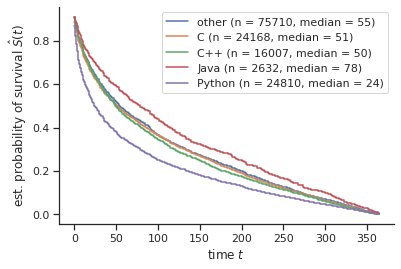

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,143327.0,1.0,48.0,0.131507,0.06,0.06,0.06


,count,median,min,max,std,mean
agg,,,,,,
Python,24810,24.0,0,364,94.243854,70.512858
C,24168,51.0,0,364,103.466444,95.376034
C++,16007,50.0,0,364,100.499125,91.988443
Java,2632,78.0,0,364,110.685451,114.378040
other,75710,55.0,0,364,104.314789,97.878787


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           143327.0 &                1.0 &                   48.0 &                0.131507 &  0.06 &                         0.06 &                          0.06 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &        mean \\
agg    &        &         &      &      &             &             \\
\midrule
Python &  24810 &    24.0 &    0 &  364 &   94.243854 &   70.512858 \\
C      &  24168 &    51.0 &    0 &  364 &  103.466444 &   95.376034 \\
C++    &  16007 &    50.0 &    0 &  364 &  100.499125 &   91.988443 \\
Java   &   2632 &    78.0 &    0 &  364 &  110.685451 &  114.378040 \\
other  &  75710 &    55.0 &    0 &  364 &  104.314789 &   97.878787 \\
\bottomrule
\end{tabular}



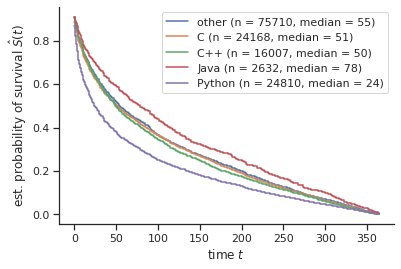

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,143327.0,1.0,48.0,0.131507,0.06,0.06,0.06


,count,median,min,max,std,mean
agg,,,,,,
Python,24810,24.0,0,364,94.243854,70.512858
C,24168,51.0,0,364,103.466444,95.376034
C++,16007,50.0,0,364,100.499125,91.988443
Java,2632,78.0,0,364,110.685451,114.378040
other,75710,55.0,0,364,104.314789,97.878787


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           143327.0 &                1.0 &                   48.0 &                0.131507 &  0.06 &                         0.06 &                          0.06 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &        mean \\
agg    &        &         &      &      &             &             \\
\midrule
Python &  24810 &    24.0 &    0 &  364 &   94.243854 &   70.512858 \\
C      &  24168 &    51.0 &    0 &  364 &  103.466444 &   95.376034 \\
C++    &  16007 &    50.0 &    0 &  364 &  100.499125 &   91.988443 \\
Java   &   2632 &    78.0 &    0 &  364 &  110.685451 &  114.378040 \\
other  &  75710 &    55.0 &    0 &  364 &  104.314789 &   97.878787 \\
\bottomrule
\end{tabular}



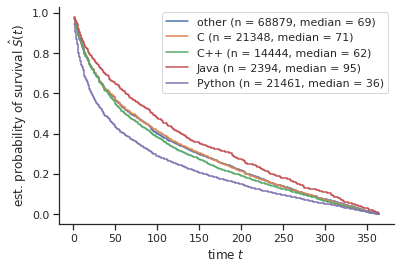

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,128526.0,1.0,62.0,0.169863,0.05,0.05,0.05


,count,median,min,max,std,mean
agg,,,,,,
Python,21461,36.0,1,364,96.803828,81.516425
C,21348,71.0,1,364,103.725998,107.974892
C++,14444,62.0,1,364,100.887390,101.942606
Java,2394,95.0,1,364,109.723571,125.748956
other,68879,69.0,1,364,104.481607,107.585810


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           128526.0 &                1.0 &                   62.0 &                0.169863 &  0.05 &                         0.05 &                          0.05 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &        mean \\
agg    &        &         &      &      &             &             \\
\midrule
Python &  21461 &    36.0 &    1 &  364 &   96.803828 &   81.516425 \\
C      &  21348 &    71.0 &    1 &  364 &  103.725998 &  107.974892 \\
C++    &  14444 &    62.0 &    1 &  364 &  100.887390 &  101.942606 \\
Java   &   2394 &    95.0 &    1 &  364 &  109.723571 &  125.748956 \\
other  &  68879 &    69.0 &    1 &  364 &  104.481607 &  107.585810 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [46]:
tiobe_top_5 = {'lang_Python':1, 'lang_C':2, 'lang_C++':3, 'lang_Java':4}


def f_map_pp(x):
    a = str(x['variable'])
    if a in tiobe_top_5:
        return tiobe_top_5[a]
    else:
        return 5

condition_names_pp = {1 : 'Python', 2: 'C', 3:'C++', 4: 'Java', 5:'other'}

compute_with_cutoff(df_languages[df_languages['Y']<365], f_map_pp, condition_names_pp, "top_5_survival_analysis")

# Popularity

In [47]:
tiobe = pd.read_csv("../data/tiobe.csv", index_col=False)
df_languages['lang'] = df_languages['variable'].map(lambda x: x.split("_")[1])
df_languages['lang'][df_languages['lang'] == 'PLSQL'] = 'SQL'

df_tiobe = df_languages.merge(tiobe[['language', 'dec2022']], how="left", left_on="lang", right_on="language")
df_tiobe['dec2022']

/tmp/ipykernel_3842559/3931425155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_languages['lang'][df_languages['lang'] == 'PLSQL'] = 'SQL'


0         30.0
1          NaN
2          2.0
3          2.0
4          2.0
          ... 
287879    41.0
287880    41.0
287881    41.0
287882    51.0
287883    51.0
Name: dec2022, Length: 287884, dtype: float64

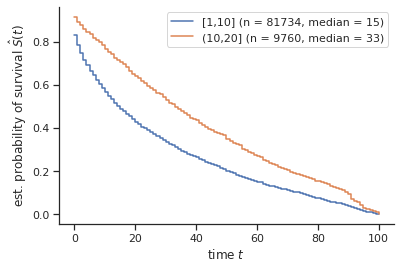

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,91494.0,0.97,17.0,0.046575,0.05,0.05,0.05


,count,median,min,max,std,mean
agg,,,,,,
"[1,10]",81734,15.0,0,100,28.235043,25.971175
"(10,20]",9760,33.0,0,100,30.932728,39.307275


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            91494.0 &               0.97 &                   17.0 &                0.046575 &  0.05 &                         0.05 &                          0.05 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg     &        &         &      &      &            &            \\
\midrule
[1,10]  &  81734 &    15.0 &    0 &  100 &  28.235043 &  25.971175 \\
(10,20] &   9760 &    33.0 &    0 &  100 &  30.932728 &  39.307275 \\
\bottomrule
\end{tabular}



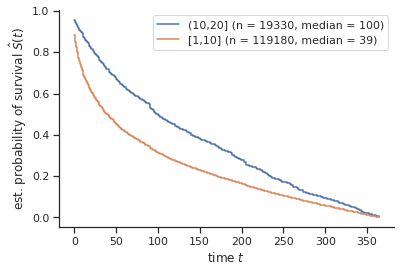

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,138510.0,0.97,47.0,0.128767,0.07,0.07,0.07


,count,median,min,max,std,mean
agg,,,,,,
"[1,10]",119180,39.0,0,364,100.226373,85.104531
"(10,20]",19330,100.0,0,364,106.918280,128.765287


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           138510.0 &               0.97 &                   47.0 &                0.128767 &  0.07 &                         0.07 &                          0.07 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &  max &         std &        mean \\
agg     &         &         &      &      &             &             \\
\midrule
[1,10]  &  119180 &    39.0 &    0 &  364 &  100.226373 &   85.104531 \\
(10,20] &   19330 &   100.0 &    0 &  364 &  106.918280 &  128.765287 \\
\bottomrule
\end{tabular}



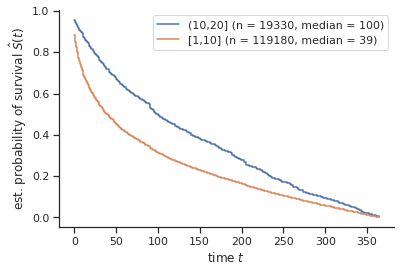

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,138510.0,0.97,47.0,0.128767,0.07,0.07,0.07


,count,median,min,max,std,mean
agg,,,,,,
"[1,10]",119180,39.0,0,364,100.226373,85.104531
"(10,20]",19330,100.0,0,364,106.918280,128.765287


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           138510.0 &               0.97 &                   47.0 &                0.128767 &  0.07 &                         0.07 &                          0.07 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &  max &         std &        mean \\
agg     &         &         &      &      &             &             \\
\midrule
[1,10]  &  119180 &    39.0 &    0 &  364 &  100.226373 &   85.104531 \\
(10,20] &   19330 &   100.0 &    0 &  364 &  106.918280 &  128.765287 \\
\bottomrule
\end{tabular}



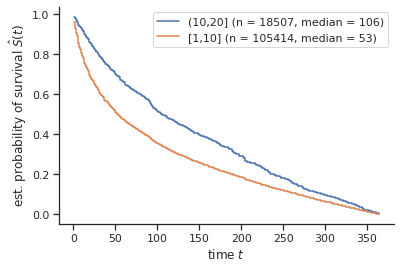

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,123921.0,0.96,61.0,0.167123,0.06,0.06,0.06


,count,median,min,max,std,mean
agg,,,,,,
"[1,10]",105414,53.0,1,364,101.428772,96.218320
"(10,20]",18507,106.0,1,364,105.687001,134.491436


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           123921.0 &               0.96 &                   61.0 &                0.167123 &  0.06 &                         0.06 &                          0.06 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &  max &         std &        mean \\
agg     &         &         &      &      &             &             \\
\midrule
[1,10]  &  105414 &    53.0 &    1 &  364 &  101.428772 &   96.218320 \\
(10,20] &   18507 &   106.0 &    1 &  364 &  105.687001 &  134.491436 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [48]:
def f_map_cc(x):
    try:
        a = int(x['dec2022'])
        if a <= 20:
            return 1
        elif a > 20:
            return 2
        else:
            return 3
    except:
        return None

condition_names_cc = {1 : '[1,10]', 2: '(10,20]', 3:"(20,100)"}
compute_with_cutoff(df_tiobe[df_tiobe['Y']<365], f_map_cc, condition_names_cc, "popularity_survival_analysis")

In [49]:
tiobe_top_5 = {'lang_Python':1, 'lang_C':2, 'lang_C++':3, 'lang_Java':4}

df_languages['top4'] = df_languages['variable'].map(lambda x: x if x in tiobe_top_5 else 'lang_other')

In [50]:
agg_lang_top = df_languages.groupby(by=['project_names', 'commit_cves']).agg({'top4':'sum'})
agg_lang_top['top'] = agg_lang_top['top4'].map(lambda x: tuple(set(x.split("lang_")[1:])))

In [51]:
agg_lang_top['number_of_languages'] = agg_lang_top['top4'].map(lambda x: len(x.split("lang_")[1:]))

In [52]:
Z = agg_lang_top.groupby(by='top').agg('count')

In [53]:
Z

,top4,number_of_languages
top,,
"(C,)",18855,18855
"(C++,)",1863,1863
"(C++, C)",62,62
"(C++, Java)",29,29
"(C++, Java, C)",2,2
"(C++, Python)",99,99
"(C++, Python, C)",2,2
"(C++, Python, Java)",1,1
"(C++, Python, Java, C)",6,6


In [54]:
X = agg_lang_top.groupby('number_of_languages').agg('count')
X.loc[:1]['top4'].sum()
X.loc[2:]['top4'].sum()

48518

49229

In [55]:
X

,top4,top
number_of_languages,,
1,48518,48518
2,22287,22287
3,11433,11433
4,2638,2638
5,2073,2073
6,1586,1586
7,1178,1178
8,1193,1193
9,833,833


In [56]:
from collections import defaultdict

rdict = defaultdict(lambda: defaultdict(int))

for r in Z.itertuples():
    for l1 in r[0]:
        for l2 in r[0]:
            rdict[l1][l2] += r[1]
            
            
for l1 in rdict:
    for l2 in rdict[l1]:
        print(f"2009, {l1}, {l2}, {rdict[l1][l2]}, {rdict[l1][l2]}")


2009, C, C, 43532, 43532
2009, C, C++, 23597, 23597
2009, C, Java, 5379, 5379
2009, C, Python, 11780, 11780
2009, C, other, 24378, 24378
2009, C++, C++, 27786, 27786
2009, C++, C, 23597, 23597
2009, C++, Java, 5387, 5387
2009, C++, Python, 11763, 11763
2009, C++, other, 25722, 25722
2009, Java, C++, 5387, 5387
2009, Java, Java, 11549, 11549
2009, Java, C, 5379, 5379
2009, Java, Python, 5305, 5305
2009, Java, other, 5643, 5643
2009, Python, C++, 11763, 11763
2009, Python, Python, 38953, 38953
2009, Python, C, 11780, 11780
2009, Python, Java, 5305, 5305
2009, Python, other, 32827, 32827
2009, other, C++, 25722, 25722
2009, other, other, 64984, 64984
2009, other, C, 24378, 24378
2009, other, Java, 5643, 5643
2009, other, Python, 32827, 32827


In [57]:
rdict

defaultdict(<function __main__.<lambda>()>,
            {'C': defaultdict(int,
                         {'C': 43532,
                          'C++': 23597,
                          'Java': 5379,
                          'Python': 11780,
                          'other': 24378}),
             'C++': defaultdict(int,
                         {'C++': 27786,
                          'C': 23597,
                          'Java': 5387,
                          'Python': 11763,
                          'other': 25722}),
             'Java': defaultdict(int,
                         {'C++': 5387,
                          'Java': 11549,
                          'C': 5379,
                          'Python': 5305,
                          'other': 5643}),
             'Python': defaultdict(int,
                         {'C++': 11763,
                          'Python': 38953,
                          'C': 11780,
                          'Java': 5305,
                          'other'

In [58]:
from chord import Chord



In [59]:
matrix = pd.DataFrame(rdict).values.tolist()
names = pd.DataFrame(rdict).columns.tolist()

fname="~/secret_life_of_CVEs/notebooks/chord.html"

#Chord(matrix,names).to_html(fname)
matrix



[[43532, 23597, 5379, 11780, 24378],
 [23597, 27786, 5387, 11763, 25722],
 [5379, 5387, 11549, 5305, 5643],
 [11780, 11763, 5305, 38953, 32827],
 [24378, 25722, 5643, 32827, 64984]]

In [60]:
%%html
<iframe src="chord.html" width="800" height="600" title="Chord diagram with the chord library" style="border:none"></iframe>


# Compilation class, Type class and Memory model for All languages
Do not use - the one with most common language are better

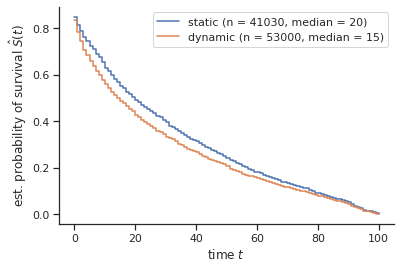

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,94030.0,1.0,17.0,0.046575,-0.04,-0.04,-0.04


,count,median,min,max,std,mean
agg,,,,,,
static,41030,20.0,0,100,29.229758,29.727175
dynamic,53000,15.0,0,100,28.607235,26.115075


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            94030.0 &                1.0 &                   17.0 &                0.046575 & -0.04 &                        -0.04 &                         -0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg     &        &         &      &      &            &            \\
\midrule
static  &  41030 &    20.0 &    0 &  100 &  29.229758 &  29.727175 \\
dynamic &  53000 &    15.0 &    0 &  100 &  28.607235 &  26.115075 \\
\bottomrule
\end{tabular}



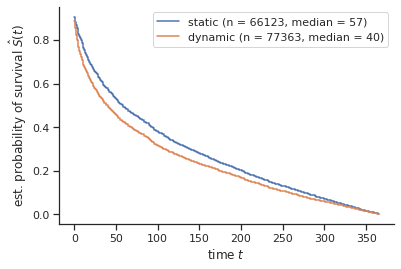

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,143486.0,1.0,49.0,0.134247,-0.05,-0.05,-0.05


,count,median,min,max,std,mean
agg,,,,,,
static,66123,57.0,0,365,104.733473,100.43652
dynamic,77363,40.0,0,365,101.151771,86.02624


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           143486.0 &                1.0 &                   49.0 &                0.134247 & -0.05 &                        -0.05 &                         -0.05 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &       mean \\
agg     &        &         &      &      &             &            \\
\midrule
static  &  66123 &    57.0 &    0 &  365 &  104.733473 &  100.43652 \\
dynamic &  77363 &    40.0 &    0 &  365 &  101.151771 &   86.02624 \\
\bottomrule
\end{tabular}



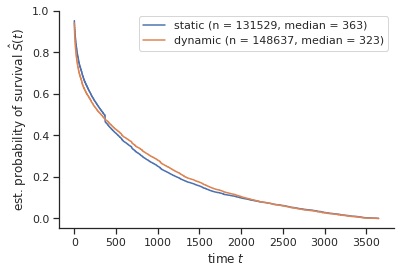

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,280166.0,1.0,342.0,0.936986,-0.01,-0.01,-0.01


,count,median,min,max,std,mean
agg,,,,,,
static,131529,363.0,0,3649,839.392455,684.227425
dynamic,148637,323.0,0,3646,858.620998,703.848207


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           280166.0 &                1.0 &                  342.0 &                0.936986 & -0.01 &                        -0.01 &                         -0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &   max &         std &        mean \\
agg     &         &         &      &       &             &             \\
\midrule
static  &  131529 &   363.0 &    0 &  3649 &  839.392455 &  684.227425 \\
dynamic &  148637 &   323.0 &    0 &  3646 &  858.620998 &  703.848207 \\
\bottomrule
\end{tabular}



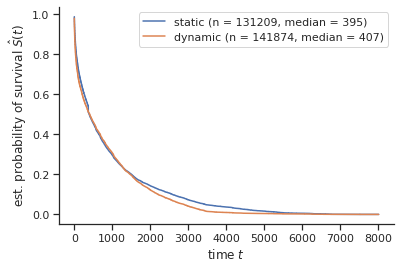

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,273083.0,1.0,403.0,1.10411,-0.02,-0.02,-0.02


,count,median,min,max,std,mean
agg,,,,,,
static,131209,395.0,1,8019,1198.370106,901.241180
dynamic,141874,407.0,1,8019,980.383214,799.960282


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           273083.0 &                1.0 &                  403.0 &                 1.10411 & -0.02 &                        -0.02 &                         -0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &   max &          std &        mean \\
agg     &         &         &      &       &              &             \\
\midrule
static  &  131209 &   395.0 &    1 &  8019 &  1198.370106 &  901.241180 \\
dynamic &  141874 &   407.0 &    1 &  8019 &   980.383214 &  799.960282 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [61]:
# to remove
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


def f_map(x):
    a = int(x['compilation_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names = {1 : 'static', 2: 'dynamic', 0: 'other'}

compute_with_cutoff(df_languages, f_map, condition_names, "all_language_compilation_class_survival_analysis")

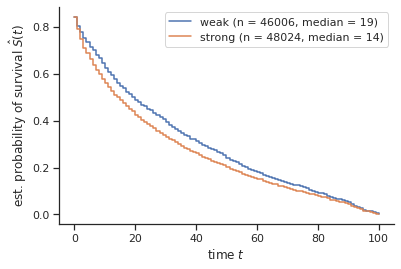

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,94030.0,1.0,17.0,0.046575,0.04,0.04,0.04


,count,median,min,max,std,mean
agg,,,,,,
strong,48024,14.0,0,100,28.361678,25.850137
weak,46006,19.0,0,100,29.400920,29.613050


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            94030.0 &                1.0 &                   17.0 &                0.046575 &  0.04 &                         0.04 &                          0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg    &        &         &      &      &            &            \\
\midrule
strong &  48024 &    14.0 &    0 &  100 &  28.361678 &  25.850137 \\
weak   &  46006 &    19.0 &    0 &  100 &  29.400920 &  29.613050 \\
\bottomrule
\end{tabular}



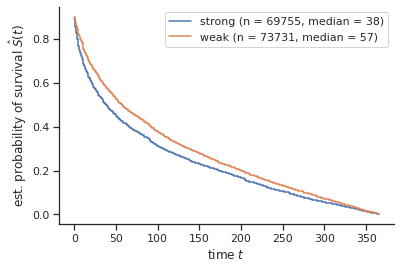

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,143486.0,1.0,49.0,0.134247,0.05,0.05,0.05


,count,median,min,max,std,mean
agg,,,,,,
strong,69755,38.0,0,365,100.426198,84.945151
weak,73731,57.0,0,365,104.985755,99.972373


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           143486.0 &                1.0 &                   49.0 &                0.134247 &  0.05 &                         0.05 &                          0.05 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &       mean \\
agg    &        &         &      &      &             &            \\
\midrule
strong &  69755 &    38.0 &    0 &  365 &  100.426198 &  84.945151 \\
weak   &  73731 &    57.0 &    0 &  365 &  104.985755 &  99.972373 \\
\bottomrule
\end{tabular}



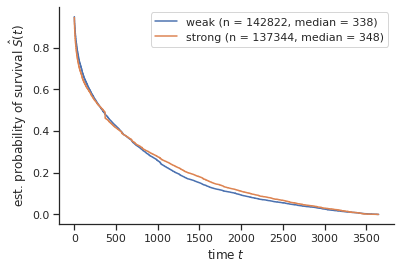

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,280166.0,1.0,342.0,0.936986,0.01,0.01,0.01


,count,median,min,max,std,mean
agg,,,,,,
strong,137344,348.0,0,3645,876.520498,711.785240
weak,142822,338.0,0,3649,822.756247,678.146245


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           280166.0 &                1.0 &                  342.0 &                0.936986 &  0.01 &                         0.01 &                          0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &   max &         std &        mean \\
agg    &         &         &      &       &             &             \\
\midrule
strong &  137344 &   348.0 &    0 &  3645 &  876.520498 &  711.785240 \\
weak   &  142822 &   338.0 &    0 &  3649 &  822.756247 &  678.146245 \\
\bottomrule
\end{tabular}



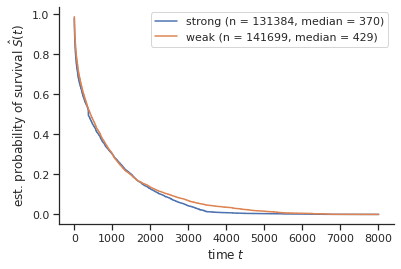

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,273083.0,1.0,403.0,1.10411,0.02,0.02,0.02


,count,median,min,max,std,mean
agg,,,,,,
strong,131384,370.0,1,8019,985.477575,800.89756
weak,141699,429.0,1,8019,1180.046458,892.87429


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           273083.0 &                1.0 &                  403.0 &                 1.10411 &  0.02 &                         0.02 &                          0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &   max &          std &       mean \\
agg    &         &         &      &       &              &            \\
\midrule
strong &  131384 &   370.0 &    1 &  8019 &   985.477575 &  800.89756 \\
weak   &  141699 &   429.0 &    1 &  8019 &  1180.046458 &  892.87429 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [62]:
# to remove
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


def f_map(x):
    a = int(x['type_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names = {1 : 'strong', 2: 'weak', 0: 'other'}

compute_with_cutoff(df_languages, f_map, condition_names, "all_language_type_class_survival_analysis")

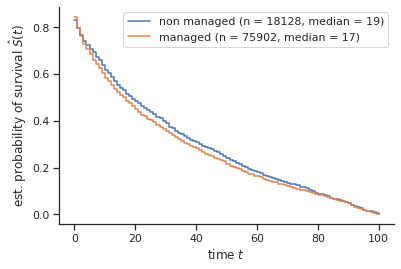

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,94030.0,1.0,17.0,0.046575,0.01,0.01,0.01


,count,median,min,max,std,mean
agg,,,,,,
managed,75902,17.0,0,100,28.811792,27.314260
non managed,18128,19.0,0,100,29.398080,29.269528


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            94030.0 &                1.0 &                   17.0 &                0.046575 &  0.01 &                         0.01 &                          0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg         &        &         &      &      &            &            \\
\midrule
managed     &  75902 &    17.0 &    0 &  100 &  28.811792 &  27.314260 \\
non managed &  18128 &    19.0 &    0 &  100 &  29.398080 &  29.269528 \\
\bottomrule
\end{tabular}



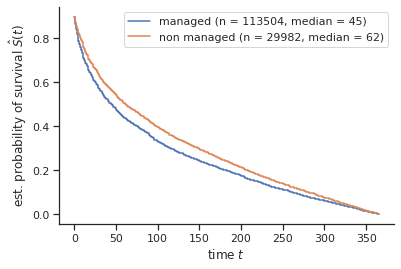

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,143486.0,1.0,49.0,0.134247,0.03,0.03,0.03


,count,median,min,max,std,mean
agg,,,,,,
managed,113504,45.0,0,365,101.876937,89.693447
non managed,29982,62.0,0,365,106.711666,103.923921


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           143486.0 &                1.0 &                   49.0 &                0.134247 &  0.03 &                         0.03 &                          0.03 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &  max &         std &        mean \\
agg         &         &         &      &      &             &             \\
\midrule
managed     &  113504 &    45.0 &    0 &  365 &  101.876937 &   89.693447 \\
non managed &   29982 &    62.0 &    0 &  365 &  106.711666 &  103.923921 \\
\bottomrule
\end{tabular}



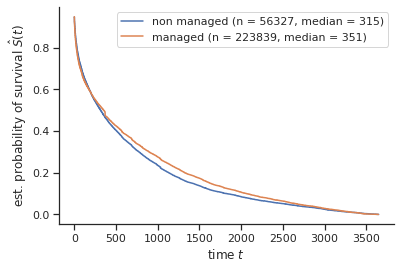

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,280166.0,1.0,342.0,0.936986,-0.01,-0.01,-0.01


,count,median,min,max,std,mean
agg,,,,,,
managed,223839,351.0,0,3646,861.091687,707.604850
non managed,56327,315.0,0,3649,800.784318,643.103183


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           280166.0 &                1.0 &                  342.0 &                0.936986 & -0.01 &                        -0.01 &                         -0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &   max &         std &        mean \\
agg         &         &         &      &       &             &             \\
\midrule
managed     &  223839 &   351.0 &    0 &  3646 &  861.091687 &  707.604850 \\
non managed &   56327 &   315.0 &    0 &  3649 &  800.784318 &  643.103183 \\
\bottomrule
\end{tabular}



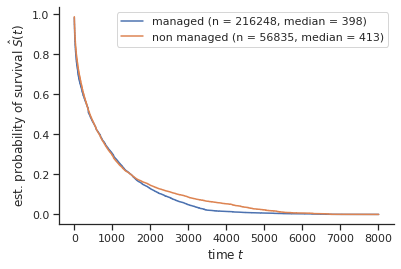

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,273083.0,1.0,403.0,1.10411,0.01,0.01,0.01


,count,median,min,max,std,mean
agg,,,,,,
managed,216248,398.0,1,8019,1032.691037,824.987644
non managed,56835,413.0,1,8019,1288.038423,938.551790


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &           273083.0 &                1.0 &                  403.0 &                 1.10411 &  0.01 &                         0.01 &                          0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &   count &  median &  min &   max &          std &        mean \\
agg         &         &         &      &       &              &             \\
\midrule
managed     &  216248 &   398.0 &    1 &  8019 &  1032.691037 &  824.987644 \\
non managed &   56835 &   413.0 &    1 &  8019 &  1288.038423 &  938.551790 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [63]:
# to remove
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

def f_map(x):
    a = int(x['memory_model'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names = {1 : 'managed', 2: 'non managed', 0: 'other'}
compute_with_cutoff(df_languages, f_map, condition_names, "all_language_memory_model_survival_analysis")

# Compilation class, Type class and Memory model for Most Common Language

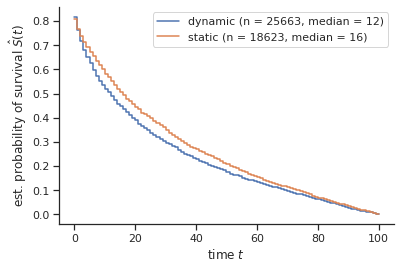

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44286.0,1.0,13.0,0.035616,-0.03,-0.03,-0.03


,count,median,min,max,std,mean
agg,,,,,,
static,18623,16.0,0,100,28.102661,26.414649
dynamic,25663,12.0,0,100,27.149640,23.355220


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44286.0 &                1.0 &                   13.0 &                0.035616 & -0.03 &                        -0.03 &                         -0.03 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg     &        &         &      &      &            &            \\
\midrule
static  &  18623 &    16.0 &    0 &  100 &  28.102661 &  26.414649 \\
dynamic &  25663 &    12.0 &    0 &  100 &  27.149640 &  23.355220 \\
\bottomrule
\end{tabular}



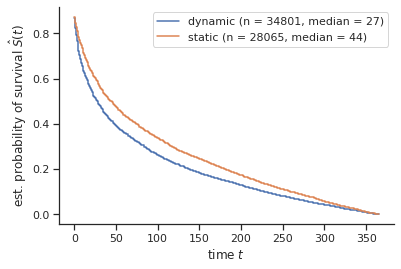

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62866.0,1.0,34.0,0.093151,-0.05,-0.05,-0.05


,count,median,min,max,std,mean
agg,,,,,,
static,28065,44.0,0,365,101.248750,89.201960
dynamic,34801,27.0,0,365,93.381057,72.001494


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62866.0 &                1.0 &                   34.0 &                0.093151 & -0.05 &                        -0.05 &                         -0.05 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &       mean \\
agg     &        &         &      &      &             &            \\
\midrule
static  &  28065 &    44.0 &    0 &  365 &  101.248750 &  89.201960 \\
dynamic &  34801 &    27.0 &    0 &  365 &   93.381057 &  72.001494 \\
\bottomrule
\end{tabular}



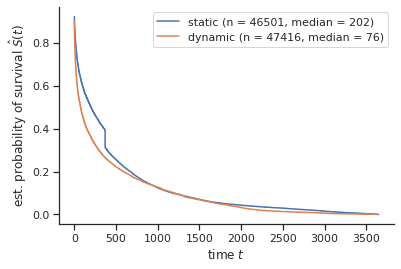

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93917.0,1.0,122.0,0.334247,-0.08,-0.08,-0.08


,count,median,min,max,std,mean
agg,,,,,,
static,46501,202.0,0,3649,646.657801,435.953162
dynamic,47416,76.0,0,3634,594.099554,356.183461


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93917.0 &                1.0 &                  122.0 &                0.334247 & -0.08 &                        -0.08 &                         -0.08 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg     &        &         &      &       &             &             \\
\midrule
static  &  46501 &   202.0 &    0 &  3649 &  646.657801 &  435.953162 \\
dynamic &  47416 &    76.0 &    0 &  3634 &  594.099554 &  356.183461 \\
\bottomrule
\end{tabular}



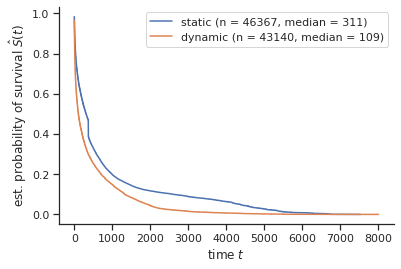

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89507.0,1.0,194.0,0.531507,-0.1,-0.1,-0.1


,count,median,min,max,std,mean
agg,,,,,,
static,46367,311.0,1,7538,1327.401462,795.920223
dynamic,43140,109.0,1,8019,735.383140,433.889430


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89507.0 &                1.0 &                  194.0 &                0.531507 & -0.1 &                         -0.1 &                          -0.1 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &        mean \\
agg     &        &         &      &       &              &             \\
\midrule
static  &  46367 &   311.0 &    1 &  7538 &  1327.401462 &  795.920223 \\
dynamic &  43140 &   109.0 &    1 &  8019 &   735.383140 &  433.889430 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [64]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


def f_map(x):
    a = int(x['compilation_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names = {1 : 'static', 2: 'dynamic', 0: 'other'}

compute_with_cutoff(df, f_map, condition_names, "most_used_language_compilation_class_survival_analysis")

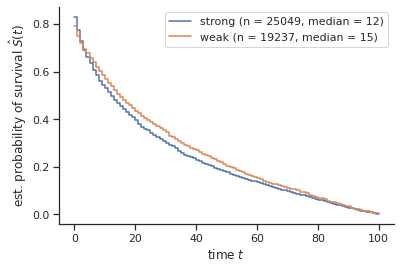

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44286.0,1.0,13.0,0.035616,0.02,0.02,0.02


,count,median,min,max,std,mean
agg,,,,,,
strong,25049,12.0,0,100,27.088757,23.636153
weak,19237,15.0,0,100,28.188620,25.951188


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44286.0 &                1.0 &                   13.0 &                0.035616 &  0.02 &                         0.02 &                          0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg    &        &         &      &      &            &            \\
\midrule
strong &  25049 &    12.0 &    0 &  100 &  27.088757 &  23.636153 \\
weak   &  19237 &    15.0 &    0 &  100 &  28.188620 &  25.951188 \\
\bottomrule
\end{tabular}



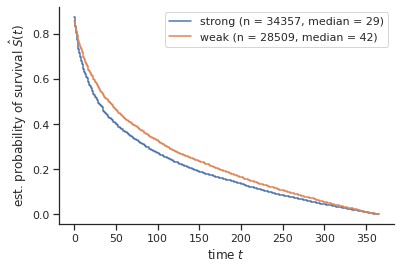

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62866.0,1.0,34.0,0.093151,0.04,0.04,0.04


,count,median,min,max,std,mean
agg,,,,,,
strong,34357,29.0,0,365,94.670707,74.080770
weak,28509,42.0,0,365,100.065470,86.428286


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62866.0 &                1.0 &                   34.0 &                0.093151 &  0.04 &                         0.04 &                          0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &       mean \\
agg    &        &         &      &      &             &            \\
\midrule
strong &  34357 &    29.0 &    0 &  365 &   94.670707 &  74.080770 \\
weak   &  28509 &    42.0 &    0 &  365 &  100.065470 &  86.428286 \\
\bottomrule
\end{tabular}



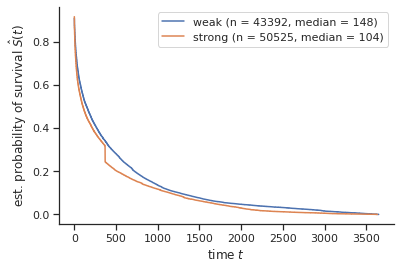

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93917.0,1.0,122.0,0.334247,0.04,0.04,0.04


,count,median,min,max,std,mean
agg,,,,,,
strong,50525,104.0,0,3634,569.903557,357.527185
weak,43392,148.0,0,3649,674.838698,440.103982


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93917.0 &                1.0 &                  122.0 &                0.334247 &  0.04 &                         0.04 &                          0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg    &        &         &      &       &             &             \\
\midrule
strong &  50525 &   104.0 &    0 &  3634 &  569.903557 &  357.527185 \\
weak   &  43392 &   148.0 &    0 &  3649 &  674.838698 &  440.103982 \\
\bottomrule
\end{tabular}



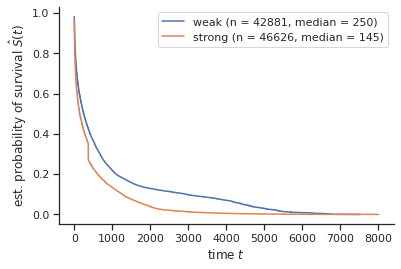

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89507.0,1.0,194.0,0.531507,0.08,0.08,0.08


,count,median,min,max,std,mean
agg,,,,,,
strong,46626,145.0,1,8019,689.053057,421.124780
weak,42881,250.0,1,7538,1382.126802,839.230871


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89507.0 &                1.0 &                  194.0 &                0.531507 &  0.08 &                         0.08 &                          0.08 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &        mean \\
agg    &        &         &      &       &              &             \\
\midrule
strong &  46626 &   145.0 &    1 &  8019 &   689.053057 &  421.124780 \\
weak   &  42881 &   250.0 &    1 &  7538 &  1382.126802 &  839.230871 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [65]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


def f_map(x):
    a = int(x['type_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names = {1 : 'strong', 2: 'weak', 0: 'other'}

compute_with_cutoff(df, f_map, condition_names, "most_used_language_type_class_survival_analysis")

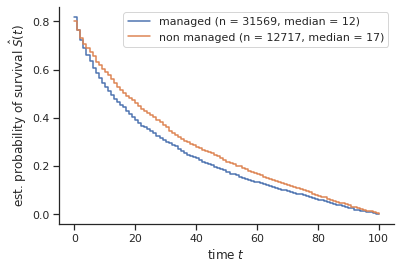

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44286.0,1.0,13.0,0.035616,0.03,0.03,0.03


,count,median,min,max,std,mean
agg,,,,,,
managed,31569,12.0,0,100,27.044482,23.588425
non managed,12717,17.0,0,100,28.752657,27.256586


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44286.0 &                1.0 &                   13.0 &                0.035616 &  0.03 &                         0.03 &                          0.03 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg         &        &         &      &      &            &            \\
\midrule
managed     &  31569 &    12.0 &    0 &  100 &  27.044482 &  23.588425 \\
non managed &  12717 &    17.0 &    0 &  100 &  28.752657 &  27.256586 \\
\bottomrule
\end{tabular}



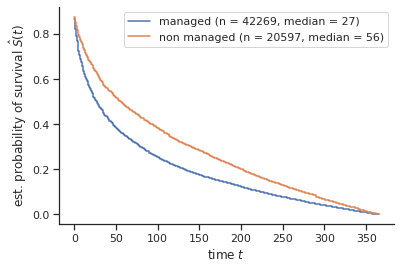

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62866.0,1.0,34.0,0.093151,0.07,0.07,0.07


,count,median,min,max,std,mean
agg,,,,,,
managed,42269,27.0,0,365,91.884146,70.253117
non managed,20597,56.0,0,365,105.081750,99.026460


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62866.0 &                1.0 &                   34.0 &                0.093151 &  0.07 &                         0.07 &                          0.07 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &       mean \\
agg         &        &         &      &      &             &            \\
\midrule
managed     &  42269 &    27.0 &    0 &  365 &   91.884146 &  70.253117 \\
non managed &  20597 &    56.0 &    0 &  365 &  105.081750 &  99.026460 \\
\bottomrule
\end{tabular}



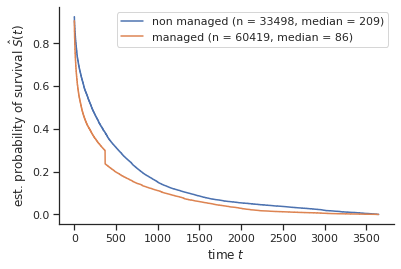

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93917.0,1.0,122.0,0.334247,0.08,0.08,0.08


,count,median,min,max,std,mean
agg,,,,,,
managed,60419,86.0,0,3646,563.293419,341.459922
non managed,33498,209.0,0,3649,705.254455,493.473819


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93917.0 &                1.0 &                  122.0 &                0.334247 &  0.08 &                         0.08 &                          0.08 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg         &        &         &      &       &             &             \\
\midrule
managed     &  60419 &    86.0 &    0 &  3646 &  563.293419 &  341.459922 \\
non managed &  33498 &   209.0 &    0 &  3649 &  705.254455 &  493.473819 \\
\bottomrule
\end{tabular}



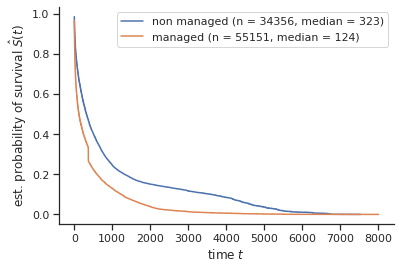

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89507.0,1.0,194.0,0.531507,0.12,0.12,0.12


,count,median,min,max,std,mean
agg,,,,,,
managed,55151,124.0,1,8019,694.613679,411.105728
non managed,34356,323.0,1,7538,1477.423533,959.061911


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89507.0 &                1.0 &                  194.0 &                0.531507 &  0.12 &                         0.12 &                          0.12 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &        mean \\
agg         &        &         &      &       &              &             \\
\midrule
managed     &  55151 &   124.0 &    1 &  8019 &   694.613679 &  411.105728 \\
non managed &  34356 &   323.0 &    1 &  7538 &  1477.423533 &  959.061911 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [66]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

def f_map(x):
    a = int(x['memory_model'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names = {1 : 'managed', 2: 'non managed', 0: 'other'}
compute_with_cutoff(df, f_map, condition_names, "most_used_language_memory_model_survival_analysis")

In [67]:
df.head()

,commits,commit_cves,project_names,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,lang_Shell,other_languages,...,NumAuthors,NumCore,CommunitySize,NumCommits,NumBlobs,NumFiles,NumForks,NumStars,E,Y
0,1,CVE-2011-1079,0-artnoc_sm-a307fn,0,3497 days 01:37:41,2978 days 21:29:59,False,False,0.0,0.0,...,1621,655,2,5233,64451,59744,1,<NA>,True,3497
1,2,CVE-2011-1079,150balbes_Amlogic_s905-kernel,0,3069 days 09:26:00,2978 days 21:29:59,False,False,0.0,0.0,...,2498,776,60,17607,433579,136904,93,123,True,3069
2,1,CVE-2011-1079,84506232_sm-g9750_graingripper,0,3098 days 12:25:02,2978 days 21:29:59,False,False,0.0,0.0,...,1721,691,3,5964,72923,65607,2,1,True,3098
3,1,CVE-2011-1079,Ante0_CarbonKernel,0,2958 days 16:10:21,2978 days 21:29:59,False,False,0.0,0.0,...,1277,536,1,3940,66416,61845,0,<NA>,True,2958
4,2,CVE-2011-1079,Backup-Gits_Eureka-Kernel-Exynos7885-Q-R,0,3751 days 10:01:38,2978 days 21:29:59,False,False,0.0,0.0,...,1946,723,1,13242,68725,61715,0,<NA>,True,3751


In [68]:
df.columns

Index(['commits', 'commit_cves', 'project_names', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'most_common_language',
       'most_common_language_number_of_files', 'programming_paradigm',
       'Programming paradigm', 'compilation_class', 'Compilation class',
       'type_class', 'Type class', 'memory_model', 'Memory model',
       'extended_programming_paradigm', 'Programming paradigm (extended)',
       'cve', 'cvss', 'cwe', 'cvss-vector', 'access.authentication',
       'access.complexity', 'access.vector', 'impact.availability',
       'impact.confidentiality', 'impact.integrity', 'CVSS v2.0 Ratings',
       'CVSS v3.1 Ratings', 'RootFork', 'EarliestCommitDate',
       'LatestCommitDate', 'NumActiveMon', 'NumAuthors', 'NumCore',
       'CommunitySize', 'NumCommits', 'NumBlobs', 'NumFiles', 'NumForks',
       'NumStars', 'E', 'Y'],
      dtype='object')

# Impact, CVSS, Access

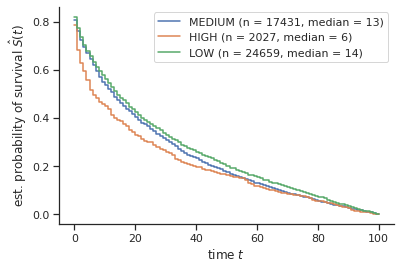

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44117.0,1.0,13.0,0.035616,0.02,0.02,0.02


,count,median,min,max,std,mean
agg,,,,,,
MEDIUM,17431,13.0,0,100,26.722834,23.711720
HIGH,2027,6.0,0,100,26.787627,20.446473
LOW,24659,14.0,0,100,28.220859,25.691756


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44117.0 &                1.0 &                   13.0 &                0.035616 &  0.02 &                         0.02 &                          0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg    &        &         &      &      &            &            \\
\midrule
MEDIUM &  17431 &    13.0 &    0 &  100 &  26.722834 &  23.711720 \\
HIGH   &   2027 &     6.0 &    0 &  100 &  26.787627 &  20.446473 \\
LOW    &  24659 &    14.0 &    0 &  100 &  28.220859 &  25.691756 \\
\bottomrule
\end{tabular}



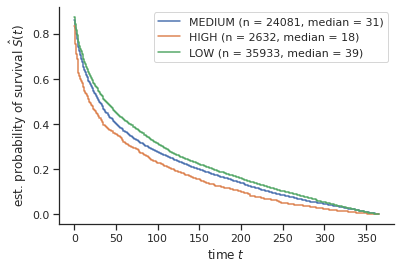

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62646.0,1.0,34.0,0.093151,0.03,0.03,0.03


,count,median,min,max,std,mean
agg,,,,,,
MEDIUM,24081,31.0,0,365,95.492401,75.475852
HIGH,2632,18.5,0,365,84.780435,60.995061
LOW,35933,39.0,0,365,99.173310,83.970501


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62646.0 &                1.0 &                   34.0 &                0.093151 &  0.03 &                         0.03 &                          0.03 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg    &        &         &      &      &            &            \\
\midrule
MEDIUM &  24081 &    31.0 &    0 &  365 &  95.492401 &  75.475852 \\
HIGH   &   2632 &    18.5 &    0 &  365 &  84.780435 &  60.995061 \\
LOW    &  35933 &    39.0 &    0 &  365 &  99.173310 &  83.970501 \\
\bottomrule
\end{tabular}



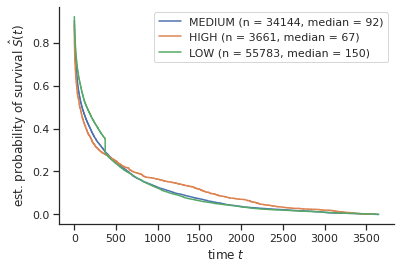

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93588.0,1.0,122.0,0.334247,0.03,0.03,0.03


,count,median,min,max,std,mean
agg,,,,,,
MEDIUM,34144,92.5,0,3649,629.891554,385.319383
HIGH,3661,67.0,0,3610,756.969612,439.681235
LOW,55783,150.0,0,3646,606.408829,398.882222


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93588.0 &                1.0 &                  122.0 &                0.334247 &  0.03 &                         0.03 &                          0.03 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg    &        &         &      &       &             &             \\
\midrule
MEDIUM &  34144 &    92.5 &    0 &  3649 &  629.891554 &  385.319383 \\
HIGH   &   3661 &    67.0 &    0 &  3610 &  756.969612 &  439.681235 \\
LOW    &  55783 &   150.0 &    0 &  3646 &  606.408829 &  398.882222 \\
\bottomrule
\end{tabular}



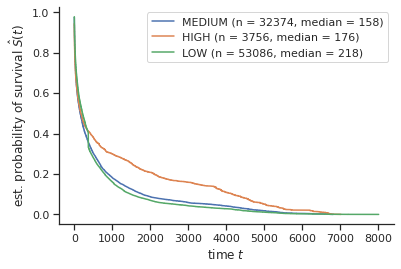

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89216.0,1.0,194.0,0.531507,0.02,0.02,0.02


,count,median,min,max,std,mean
agg,,,,,,
MEDIUM,32374,158.0,1,6820,1151.672500,641.503398
HIGH,3756,176.0,1,7022,1705.098810,1103.409478
LOW,53086,218.0,1,8019,996.406323,574.747862


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89216.0 &                1.0 &                  194.0 &                0.531507 &  0.02 &                         0.02 &                          0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &         mean \\
agg    &        &         &      &       &              &              \\
\midrule
MEDIUM &  32374 &   158.0 &    1 &  6820 &  1151.672500 &   641.503398 \\
HIGH   &   3756 &   176.0 &    1 &  7022 &  1705.098810 &  1103.409478 \\
LOW    &  53086 &   218.0 &    1 &  8019 &   996.406323 &   574.747862 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [69]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
languagesl = df['access.complexity'].unique()

languages = dict(zip(languagesl, range(len(languagesl))))

condition_names = dict(zip(range(len(languagesl)), languagesl))

def f_map(x):
    a = x['access.complexity']
    if pd.isnull(a):
        return None
    return languages[a]

compute_with_cutoff(df, f_map, condition_names, "most_used_language_access_complexity_survival_analysis")

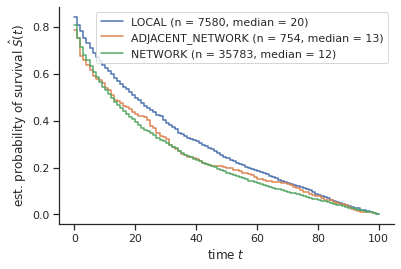

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44117.0,1.0,13.0,0.035616,-0.04,-0.04,-0.04


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,7580,20.0,0,100,29.010601,29.469129
ADJACENT_NETWORK,754,13.0,0,99,28.466297,24.942971
NETWORK,35783,12.0,0,100,27.170593,23.645698


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44117.0 &                1.0 &                   13.0 &                0.035616 & -0.04 &                        -0.04 &                         -0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg              &        &         &      &      &            &            \\
\midrule
LOCAL            &   7580 &    20.0 &    0 &  100 &  29.010601 &  29.469129 \\
ADJACENT\_NETWORK &    754 &    13.0 &    0 &   99 &  28.466297 &  24.942971 \\
NETWORK          &  35783 &    12.0 &    0 &  100 &  27.170593 &  23.645698 \\
\bottomrule
\end{tabular}



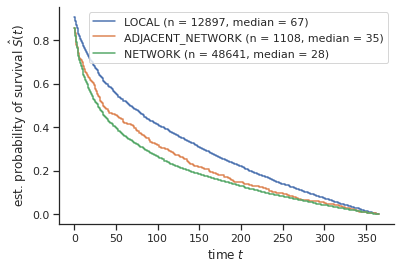

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62646.0,1.0,34.0,0.093151,-0.07,-0.07,-0.07


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,12897,67.0,0,365,106.193481,106.444832
ADJACENT_NETWORK,1108,35.0,0,365,97.537972,82.707581
NETWORK,48641,28.0,0,365,93.612581,72.591559


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62646.0 &                1.0 &                   34.0 &                0.093151 & -0.07 &                        -0.07 &                         -0.07 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &        mean \\
agg              &        &         &      &      &             &             \\
\midrule
LOCAL            &  12897 &    67.0 &    0 &  365 &  106.193481 &  106.444832 \\
ADJACENT\_NETWORK &   1108 &    35.0 &    0 &  365 &   97.537972 &   82.707581 \\
NETWORK          &  48641 &    28.0 &    0 &  365 &   93.612581 &   72.591559 \\
\bottomrule
\end{tabular}



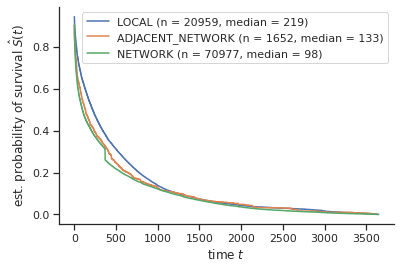

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93588.0,1.0,122.0,0.334247,-0.06,-0.06,-0.06


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,20959,219.0,0,3649,660.111859,473.996231
ADJACENT_NETWORK,1652,133.0,0,3633,658.937422,414.190073
NETWORK,70977,98.0,0,3646,606.983172,371.925215


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93588.0 &                1.0 &                  122.0 &                0.334247 & -0.06 &                        -0.06 &                         -0.06 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg              &        &         &      &       &             &             \\
\midrule
LOCAL            &  20959 &   219.0 &    0 &  3649 &  660.111859 &  473.996231 \\
ADJACENT\_NETWORK &   1652 &   133.0 &    0 &  3633 &  658.937422 &  414.190073 \\
NETWORK          &  70977 &    98.0 &    0 &  3646 &  606.983172 &  371.925215 \\
\bottomrule
\end{tabular}



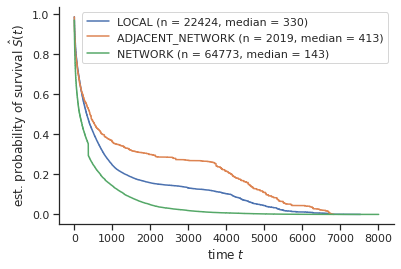

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89216.0,1.0,194.0,0.531507,-0.1,-0.1,-0.1


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,22424,330.0,1,7538,1559.957587,1014.756689
ADJACENT_NETWORK,2019,413.0,1,6839,2096.721933,1621.982665
NETWORK,64773,143.0,1,8019,753.884939,453.797338


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89216.0 &                1.0 &                  194.0 &                0.531507 & -0.1 &                         -0.1 &                          -0.1 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &         mean \\
agg              &        &         &      &       &              &              \\
\midrule
LOCAL            &  22424 &   330.0 &    1 &  7538 &  1559.957587 &  1014.756689 \\
ADJACENT\_NETWORK &   2019 &   413.0 &    1 &  6839 &  2096.721933 &  1621.982665 \\
NETWORK          &  64773 &   143.0 &    1 &  8019 &   753.884939 &   453.797338 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [70]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

languagesl = df['access.vector'].unique()

languages = dict(zip(languagesl, range(len(languagesl))))

condition_names = dict(zip(range(len(languagesl)), languagesl))


def f_map(x):
    a = x['access.vector']
    if pd.isnull(a):
        return None
    return languages[a]

compute_with_cutoff(df, f_map, condition_names, "most_used_language_access_vector_survival_analysis")

In [71]:
df['cvss-vector'].unique()

<StringArray>
['AV:L/AC:M/Au:N/C:P/I:N/A:C', 'AV:A/AC:H/Au:N/C:C/I:N/A:C',
 'AV:L/AC:M/Au:N/C:C/I:N/A:N', 'AV:L/AC:L/Au:N/C:N/I:C/A:N',
 'AV:L/AC:L/Au:N/C:N/I:N/A:P', 'AV:N/AC:L/Au:N/C:N/I:N/A:C',
 'AV:N/AC:L/Au:N/C:N/I:N/A:P', 'AV:L/AC:L/Au:N/C:N/I:N/A:C',
 'AV:L/AC:M/Au:N/C:P/I:N/A:N', 'AV:L/AC:L/Au:N/C:C/I:C/A:C',
 ...
 'AV:A/AC:M/Au:S/C:P/I:N/A:C', 'AV:L/AC:H/Au:M/C:P/I:P/A:P',
 'AV:N/AC:H/Au:M/C:P/I:P/A:P', 'AV:L/AC:M/Au:N/C:N/I:C/A:N',
 'AV:N/AC:L/Au:M/C:N/I:P/A:N', 'AV:N/AC:M/Au:S/C:C/I:N/A:C',
 'AV:A/AC:H/Au:N/C:N/I:N/A:P', 'AV:N/AC:L/Au:M/C:C/I:C/A:N',
 'AV:N/AC:L/Au:M/C:N/I:N/A:P', 'AV:N/AC:L/Au:S/C:C/I:P/A:N']
Length: 221, dtype: string

In [72]:
def decode_cvssvector(name):
    ret = {'cvssv_A': None, 'cvssv_AC': None, 'cvssv_AV': None, 'cvssv_Au': None, 'cvssv_C': None, 'cvssv_I': None}
    if not isinstance(name, str):
        #print("Error not string")
        return ret
    kvs = name.split("/")
    for kv in kvs:
        k,v = kv.split(":")
        #global_names.append(k)
        #global_values.append(v)
        #if k in ret:
        #    print("Error " + name)
        ret['cvssv_'+k] = v
    return ret

In [73]:
d = df['cvss-vector'].map(decode_cvssvector)

In [74]:
Z = pd.DataFrame(d.tolist())

In [75]:
Z['cvssv_AV'].unique()

array(['L', 'A', 'N', None], dtype=object)

In [76]:
df_ext = pd.concat([df, Z], axis=1)

In [77]:
df_ext.head()

,commits,commit_cves,project_names,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,lang_Shell,other_languages,...,NumForks,NumStars,E,Y,cvssv_A,cvssv_AC,cvssv_AV,cvssv_Au,cvssv_C,cvssv_I
0,1,CVE-2011-1079,0-artnoc_sm-a307fn,0,3497 days 01:37:41,2978 days 21:29:59,False,False,0.0,0.0,...,1,<NA>,True,3497,C,M,L,N,P,N
1,2,CVE-2011-1079,150balbes_Amlogic_s905-kernel,0,3069 days 09:26:00,2978 days 21:29:59,False,False,0.0,0.0,...,93,123,True,3069,C,M,L,N,P,N
2,1,CVE-2011-1079,84506232_sm-g9750_graingripper,0,3098 days 12:25:02,2978 days 21:29:59,False,False,0.0,0.0,...,2,1,True,3098,C,M,L,N,P,N
3,1,CVE-2011-1079,Ante0_CarbonKernel,0,2958 days 16:10:21,2978 days 21:29:59,False,False,0.0,0.0,...,0,<NA>,True,2958,C,M,L,N,P,N
4,2,CVE-2011-1079,Backup-Gits_Eureka-Kernel-Exynos7885-Q-R,0,3751 days 10:01:38,2978 days 21:29:59,False,False,0.0,0.0,...,0,<NA>,True,3751,C,M,L,N,P,N


In [78]:
df.columns

Index(['commits', 'commit_cves', 'project_names', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'most_common_language',
       'most_common_language_number_of_files', 'programming_paradigm',
       'Programming paradigm', 'compilation_class', 'Compilation class',
       'type_class', 'Type class', 'memory_model', 'Memory model',
       'extended_programming_paradigm', 'Programming paradigm (extended)',
       'cve', 'cvss', 'cwe', 'cvss-vector', 'access.authentication',
       'access.complexity', 'access.vector', 'impact.availability',
       'impact.confidentiality', 'impact.integrity', 'CVSS v2.0 Ratings',
       'CVSS v3.1 Ratings', 'RootFork', 'EarliestCommitDate',
       'LatestCommitDate', 'NumActiveMon', 'NumAuthors', 'NumCore',
       'CommunitySize', 'NumCommits', 'NumBlobs', 'NumFiles', 'NumForks',
       'NumStars', 'E', 'Y'],
      dtype='object')

In [79]:
df_ext.columns

Index(['commits', 'commit_cves', 'project_names', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'most_common_language',
       'most_common_language_number_of_files', 'programming_paradigm',
       'Programming paradigm', 'compilation_class', 'Compilation class',
       'type_class', 'Type class', 'memory_model', 'Memory model',
       'extended_programming_paradigm', 'Programming paradigm (extended)',
       'cve', 'cvss', 'cwe', 'cvss-vector', 'access.authentication',
       'access.complexity', 'access.vector', 'impact.availability',
       'impact.confidentiality', 'impact.integrity', 'CVSS v2.0 Ratings',
       'CVSS v3.1 Ratings', 'RootFork', 'EarliestCommitDate',
       'LatestCommitDate', 'NumActiveMon', 'NumAuthors', 'NumCore',
       'CommunitySize', 'NumCommits', 'NumBlobs', 'NumFiles', 'NumForks',
       'NumStars', 'E', 'Y', 'cvssv_A', 'cvssv_AC', 'cvssv_AV', 'cvssv

In [80]:
def naive_compute(df_in, vname, graph_filename, typesl=None):

    print(vname)
    if typesl is None:
        typesl = df_in[vname].dropna().unique()

    types = dict(zip(typesl, range(len(typesl))))
    print(types)


    condition_names_mm = dict(zip(range(len(typesl)), typesl))

    def f_map_mm(x):
        try:
            a = x[vname]
            if pd.isnull(a):
                return None
            return types[a]
        except:
            return None

    
    compute_with_cutoff(df, f_map, condition_names, graph_filename+str(vname))

['C' 'N' 'P']
cvssv_A
{'N': 0, 'P': 1, 'C': 2}


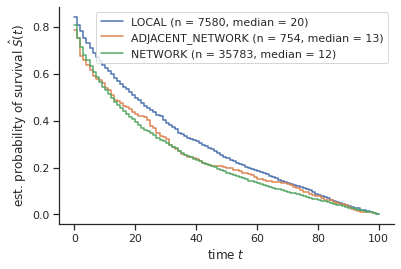

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44117.0,1.0,13.0,0.035616,-0.04,-0.04,-0.04


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,7580,20.0,0,100,29.010601,29.469129
ADJACENT_NETWORK,754,13.0,0,99,28.466297,24.942971
NETWORK,35783,12.0,0,100,27.170593,23.645698


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44117.0 &                1.0 &                   13.0 &                0.035616 & -0.04 &                        -0.04 &                         -0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg              &        &         &      &      &            &            \\
\midrule
LOCAL            &   7580 &    20.0 &    0 &  100 &  29.010601 &  29.469129 \\
ADJACENT\_NETWORK &    754 &    13.0 &    0 &   99 &  28.466297 &  24.942971 \\
NETWORK          &  35783 &    12.0 &    0 &  100 &  27.170593 &  23.645698 \\
\bottomrule
\end{tabular}



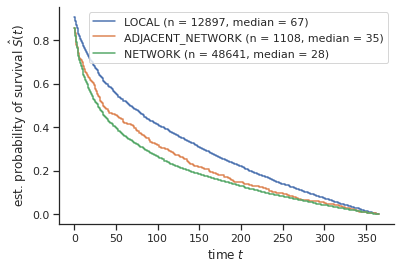

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62646.0,1.0,34.0,0.093151,-0.07,-0.07,-0.07


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,12897,67.0,0,365,106.193481,106.444832
ADJACENT_NETWORK,1108,35.0,0,365,97.537972,82.707581
NETWORK,48641,28.0,0,365,93.612581,72.591559


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62646.0 &                1.0 &                   34.0 &                0.093151 & -0.07 &                        -0.07 &                         -0.07 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &        mean \\
agg              &        &         &      &      &             &             \\
\midrule
LOCAL            &  12897 &    67.0 &    0 &  365 &  106.193481 &  106.444832 \\
ADJACENT\_NETWORK &   1108 &    35.0 &    0 &  365 &   97.537972 &   82.707581 \\
NETWORK          &  48641 &    28.0 &    0 &  365 &   93.612581 &   72.591559 \\
\bottomrule
\end{tabular}



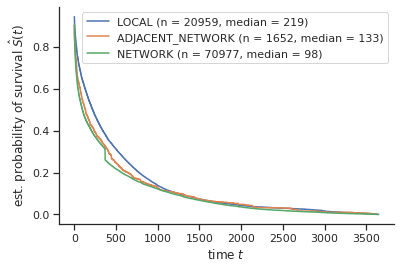

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93588.0,1.0,122.0,0.334247,-0.06,-0.06,-0.06


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,20959,219.0,0,3649,660.111859,473.996231
ADJACENT_NETWORK,1652,133.0,0,3633,658.937422,414.190073
NETWORK,70977,98.0,0,3646,606.983172,371.925215


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93588.0 &                1.0 &                  122.0 &                0.334247 & -0.06 &                        -0.06 &                         -0.06 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg              &        &         &      &       &             &             \\
\midrule
LOCAL            &  20959 &   219.0 &    0 &  3649 &  660.111859 &  473.996231 \\
ADJACENT\_NETWORK &   1652 &   133.0 &    0 &  3633 &  658.937422 &  414.190073 \\
NETWORK          &  70977 &    98.0 &    0 &  3646 &  606.983172 &  371.925215 \\
\bottomrule
\end{tabular}



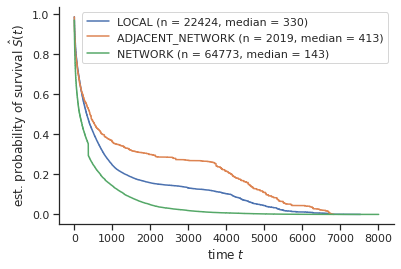

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89216.0,1.0,194.0,0.531507,-0.1,-0.1,-0.1


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,22424,330.0,1,7538,1559.957587,1014.756689
ADJACENT_NETWORK,2019,413.0,1,6839,2096.721933,1621.982665
NETWORK,64773,143.0,1,8019,753.884939,453.797338


/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89216.0 &                1.0 &                  194.0 &                0.531507 & -0.1 &                         -0.1 &                          -0.1 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &         mean \\
agg              &        &         &      &       &              &              \\
\midrule
LOCAL            &  22424 &   330.0 &    1 &  7538 &  1559.957587 &  1014.756689 \\
ADJACENT\_NETWORK &   2019 &   413.0 &    1 &  6839 &  2096.721933 &  1621.982665 \\
NETWORK          &  64773 &   143.0 &    1 &  8019 &   753.884939 &   453.797338 \\
\bottomrule
\end{tabular}

['M' 'H' 'L']
cvssv_AC
{'L': 0, 'M': 1, 'H': 2}


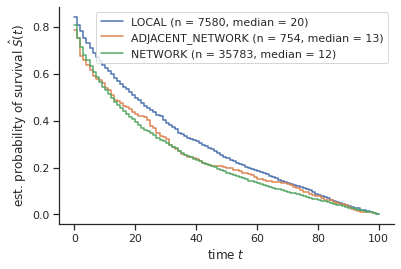

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44117.0,1.0,13.0,0.035616,-0.04,-0.04,-0.04


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,7580,20.0,0,100,29.010601,29.469129
ADJACENT_NETWORK,754,13.0,0,99,28.466297,24.942971
NETWORK,35783,12.0,0,100,27.170593,23.645698


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44117.0 &                1.0 &                   13.0 &                0.035616 & -0.04 &                        -0.04 &                         -0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg              &        &         &      &      &            &            \\
\midrule
LOCAL            &   7580 &    20.0 &    0 &  100 &  29.010601 &  29.469129 \\
ADJACENT\_NETWORK &    754 &    13.0 &    0 &   99 &  28.466297 &  24.942971 \\
NETWORK          &  35783 &    12.0 &    0 &  100 &  27.170593 &  23.645698 \\
\bottomrule
\end{tabular}



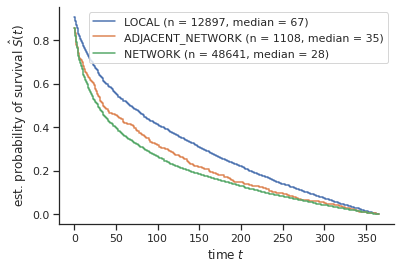

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62646.0,1.0,34.0,0.093151,-0.07,-0.07,-0.07


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,12897,67.0,0,365,106.193481,106.444832
ADJACENT_NETWORK,1108,35.0,0,365,97.537972,82.707581
NETWORK,48641,28.0,0,365,93.612581,72.591559


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62646.0 &                1.0 &                   34.0 &                0.093151 & -0.07 &                        -0.07 &                         -0.07 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &        mean \\
agg              &        &         &      &      &             &             \\
\midrule
LOCAL            &  12897 &    67.0 &    0 &  365 &  106.193481 &  106.444832 \\
ADJACENT\_NETWORK &   1108 &    35.0 &    0 &  365 &   97.537972 &   82.707581 \\
NETWORK          &  48641 &    28.0 &    0 &  365 &   93.612581 &   72.591559 \\
\bottomrule
\end{tabular}



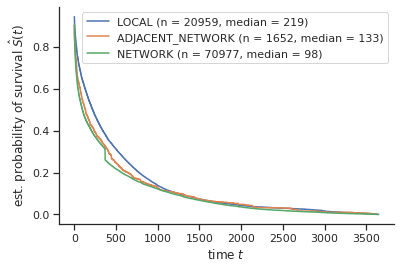

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93588.0,1.0,122.0,0.334247,-0.06,-0.06,-0.06


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,20959,219.0,0,3649,660.111859,473.996231
ADJACENT_NETWORK,1652,133.0,0,3633,658.937422,414.190073
NETWORK,70977,98.0,0,3646,606.983172,371.925215


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93588.0 &                1.0 &                  122.0 &                0.334247 & -0.06 &                        -0.06 &                         -0.06 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg              &        &         &      &       &             &             \\
\midrule
LOCAL            &  20959 &   219.0 &    0 &  3649 &  660.111859 &  473.996231 \\
ADJACENT\_NETWORK &   1652 &   133.0 &    0 &  3633 &  658.937422 &  414.190073 \\
NETWORK          &  70977 &    98.0 &    0 &  3646 &  606.983172 &  371.925215 \\
\bottomrule
\end{tabular}



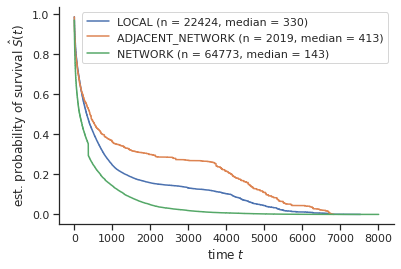

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89216.0,1.0,194.0,0.531507,-0.1,-0.1,-0.1


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,22424,330.0,1,7538,1559.957587,1014.756689
ADJACENT_NETWORK,2019,413.0,1,6839,2096.721933,1621.982665
NETWORK,64773,143.0,1,8019,753.884939,453.797338


/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89216.0 &                1.0 &                  194.0 &                0.531507 & -0.1 &                         -0.1 &                          -0.1 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &         mean \\
agg              &        &         &      &       &              &              \\
\midrule
LOCAL            &  22424 &   330.0 &    1 &  7538 &  1559.957587 &  1014.756689 \\
ADJACENT\_NETWORK &   2019 &   413.0 &    1 &  6839 &  2096.721933 &  1621.982665 \\
NETWORK          &  64773 &   143.0 &    1 &  8019 &   753.884939 &   453.797338 \\
\bottomrule
\end{tabular}

['L' 'A' 'N']
cvssv_AV
{'L': 0, 'A': 1, 'N': 2}


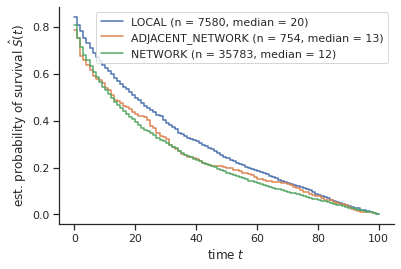

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44117.0,1.0,13.0,0.035616,-0.04,-0.04,-0.04


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,7580,20.0,0,100,29.010601,29.469129
ADJACENT_NETWORK,754,13.0,0,99,28.466297,24.942971
NETWORK,35783,12.0,0,100,27.170593,23.645698


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44117.0 &                1.0 &                   13.0 &                0.035616 & -0.04 &                        -0.04 &                         -0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg              &        &         &      &      &            &            \\
\midrule
LOCAL            &   7580 &    20.0 &    0 &  100 &  29.010601 &  29.469129 \\
ADJACENT\_NETWORK &    754 &    13.0 &    0 &   99 &  28.466297 &  24.942971 \\
NETWORK          &  35783 &    12.0 &    0 &  100 &  27.170593 &  23.645698 \\
\bottomrule
\end{tabular}



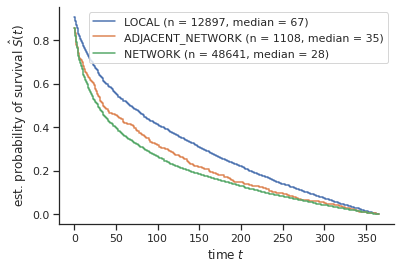

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62646.0,1.0,34.0,0.093151,-0.07,-0.07,-0.07


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,12897,67.0,0,365,106.193481,106.444832
ADJACENT_NETWORK,1108,35.0,0,365,97.537972,82.707581
NETWORK,48641,28.0,0,365,93.612581,72.591559


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62646.0 &                1.0 &                   34.0 &                0.093151 & -0.07 &                        -0.07 &                         -0.07 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &        mean \\
agg              &        &         &      &      &             &             \\
\midrule
LOCAL            &  12897 &    67.0 &    0 &  365 &  106.193481 &  106.444832 \\
ADJACENT\_NETWORK &   1108 &    35.0 &    0 &  365 &   97.537972 &   82.707581 \\
NETWORK          &  48641 &    28.0 &    0 &  365 &   93.612581 &   72.591559 \\
\bottomrule
\end{tabular}



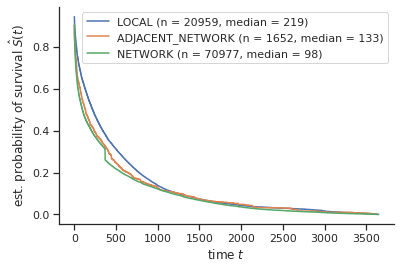

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93588.0,1.0,122.0,0.334247,-0.06,-0.06,-0.06


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,20959,219.0,0,3649,660.111859,473.996231
ADJACENT_NETWORK,1652,133.0,0,3633,658.937422,414.190073
NETWORK,70977,98.0,0,3646,606.983172,371.925215


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93588.0 &                1.0 &                  122.0 &                0.334247 & -0.06 &                        -0.06 &                         -0.06 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg              &        &         &      &       &             &             \\
\midrule
LOCAL            &  20959 &   219.0 &    0 &  3649 &  660.111859 &  473.996231 \\
ADJACENT\_NETWORK &   1652 &   133.0 &    0 &  3633 &  658.937422 &  414.190073 \\
NETWORK          &  70977 &    98.0 &    0 &  3646 &  606.983172 &  371.925215 \\
\bottomrule
\end{tabular}



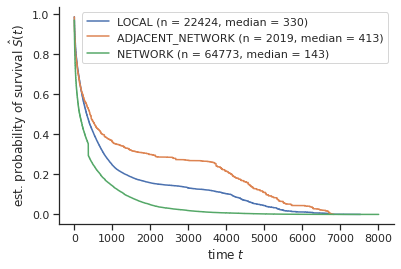

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89216.0,1.0,194.0,0.531507,-0.1,-0.1,-0.1


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,22424,330.0,1,7538,1559.957587,1014.756689
ADJACENT_NETWORK,2019,413.0,1,6839,2096.721933,1621.982665
NETWORK,64773,143.0,1,8019,753.884939,453.797338


/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89216.0 &                1.0 &                  194.0 &                0.531507 & -0.1 &                         -0.1 &                          -0.1 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &         mean \\
agg              &        &         &      &       &              &              \\
\midrule
LOCAL            &  22424 &   330.0 &    1 &  7538 &  1559.957587 &  1014.756689 \\
ADJACENT\_NETWORK &   2019 &   413.0 &    1 &  6839 &  2096.721933 &  1621.982665 \\
NETWORK          &  64773 &   143.0 &    1 &  8019 &   753.884939 &   453.797338 \\
\bottomrule
\end{tabular}

['N' 'S' 'M']
cvssv_Au
{'N': 0, 'S': 1, 'M': 2}


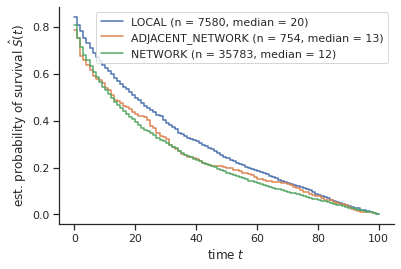

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44117.0,1.0,13.0,0.035616,-0.04,-0.04,-0.04


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,7580,20.0,0,100,29.010601,29.469129
ADJACENT_NETWORK,754,13.0,0,99,28.466297,24.942971
NETWORK,35783,12.0,0,100,27.170593,23.645698


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44117.0 &                1.0 &                   13.0 &                0.035616 & -0.04 &                        -0.04 &                         -0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg              &        &         &      &      &            &            \\
\midrule
LOCAL            &   7580 &    20.0 &    0 &  100 &  29.010601 &  29.469129 \\
ADJACENT\_NETWORK &    754 &    13.0 &    0 &   99 &  28.466297 &  24.942971 \\
NETWORK          &  35783 &    12.0 &    0 &  100 &  27.170593 &  23.645698 \\
\bottomrule
\end{tabular}



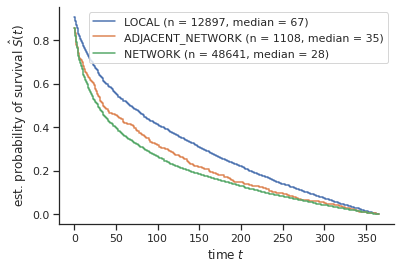

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62646.0,1.0,34.0,0.093151,-0.07,-0.07,-0.07


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,12897,67.0,0,365,106.193481,106.444832
ADJACENT_NETWORK,1108,35.0,0,365,97.537972,82.707581
NETWORK,48641,28.0,0,365,93.612581,72.591559


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62646.0 &                1.0 &                   34.0 &                0.093151 & -0.07 &                        -0.07 &                         -0.07 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &        mean \\
agg              &        &         &      &      &             &             \\
\midrule
LOCAL            &  12897 &    67.0 &    0 &  365 &  106.193481 &  106.444832 \\
ADJACENT\_NETWORK &   1108 &    35.0 &    0 &  365 &   97.537972 &   82.707581 \\
NETWORK          &  48641 &    28.0 &    0 &  365 &   93.612581 &   72.591559 \\
\bottomrule
\end{tabular}



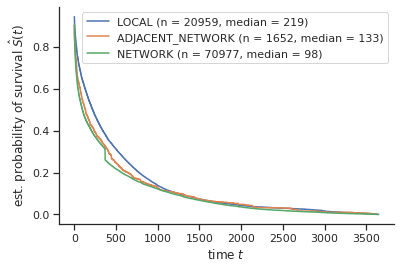

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93588.0,1.0,122.0,0.334247,-0.06,-0.06,-0.06


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,20959,219.0,0,3649,660.111859,473.996231
ADJACENT_NETWORK,1652,133.0,0,3633,658.937422,414.190073
NETWORK,70977,98.0,0,3646,606.983172,371.925215


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93588.0 &                1.0 &                  122.0 &                0.334247 & -0.06 &                        -0.06 &                         -0.06 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg              &        &         &      &       &             &             \\
\midrule
LOCAL            &  20959 &   219.0 &    0 &  3649 &  660.111859 &  473.996231 \\
ADJACENT\_NETWORK &   1652 &   133.0 &    0 &  3633 &  658.937422 &  414.190073 \\
NETWORK          &  70977 &    98.0 &    0 &  3646 &  606.983172 &  371.925215 \\
\bottomrule
\end{tabular}



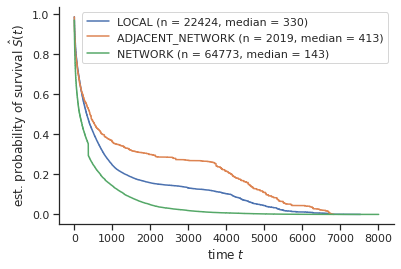

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89216.0,1.0,194.0,0.531507,-0.1,-0.1,-0.1


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,22424,330.0,1,7538,1559.957587,1014.756689
ADJACENT_NETWORK,2019,413.0,1,6839,2096.721933,1621.982665
NETWORK,64773,143.0,1,8019,753.884939,453.797338


/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89216.0 &                1.0 &                  194.0 &                0.531507 & -0.1 &                         -0.1 &                          -0.1 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &         mean \\
agg              &        &         &      &       &              &              \\
\midrule
LOCAL            &  22424 &   330.0 &    1 &  7538 &  1559.957587 &  1014.756689 \\
ADJACENT\_NETWORK &   2019 &   413.0 &    1 &  6839 &  2096.721933 &  1621.982665 \\
NETWORK          &  64773 &   143.0 &    1 &  8019 &   753.884939 &   453.797338 \\
\bottomrule
\end{tabular}

['P' 'C' 'N']
cvssv_C
{'N': 0, 'P': 1, 'C': 2}


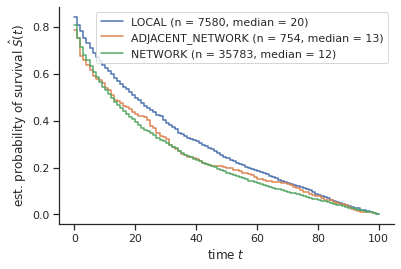

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44117.0,1.0,13.0,0.035616,-0.04,-0.04,-0.04


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,7580,20.0,0,100,29.010601,29.469129
ADJACENT_NETWORK,754,13.0,0,99,28.466297,24.942971
NETWORK,35783,12.0,0,100,27.170593,23.645698


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44117.0 &                1.0 &                   13.0 &                0.035616 & -0.04 &                        -0.04 &                         -0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg              &        &         &      &      &            &            \\
\midrule
LOCAL            &   7580 &    20.0 &    0 &  100 &  29.010601 &  29.469129 \\
ADJACENT\_NETWORK &    754 &    13.0 &    0 &   99 &  28.466297 &  24.942971 \\
NETWORK          &  35783 &    12.0 &    0 &  100 &  27.170593 &  23.645698 \\
\bottomrule
\end{tabular}



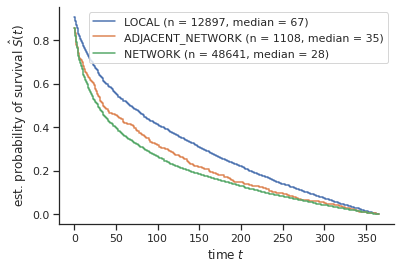

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62646.0,1.0,34.0,0.093151,-0.07,-0.07,-0.07


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,12897,67.0,0,365,106.193481,106.444832
ADJACENT_NETWORK,1108,35.0,0,365,97.537972,82.707581
NETWORK,48641,28.0,0,365,93.612581,72.591559


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62646.0 &                1.0 &                   34.0 &                0.093151 & -0.07 &                        -0.07 &                         -0.07 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &        mean \\
agg              &        &         &      &      &             &             \\
\midrule
LOCAL            &  12897 &    67.0 &    0 &  365 &  106.193481 &  106.444832 \\
ADJACENT\_NETWORK &   1108 &    35.0 &    0 &  365 &   97.537972 &   82.707581 \\
NETWORK          &  48641 &    28.0 &    0 &  365 &   93.612581 &   72.591559 \\
\bottomrule
\end{tabular}



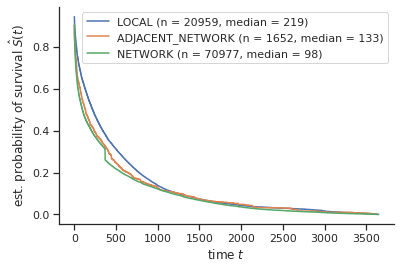

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93588.0,1.0,122.0,0.334247,-0.06,-0.06,-0.06


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,20959,219.0,0,3649,660.111859,473.996231
ADJACENT_NETWORK,1652,133.0,0,3633,658.937422,414.190073
NETWORK,70977,98.0,0,3646,606.983172,371.925215


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93588.0 &                1.0 &                  122.0 &                0.334247 & -0.06 &                        -0.06 &                         -0.06 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg              &        &         &      &       &             &             \\
\midrule
LOCAL            &  20959 &   219.0 &    0 &  3649 &  660.111859 &  473.996231 \\
ADJACENT\_NETWORK &   1652 &   133.0 &    0 &  3633 &  658.937422 &  414.190073 \\
NETWORK          &  70977 &    98.0 &    0 &  3646 &  606.983172 &  371.925215 \\
\bottomrule
\end{tabular}



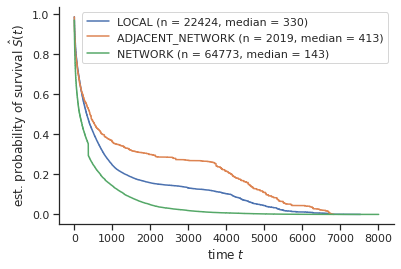

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89216.0,1.0,194.0,0.531507,-0.1,-0.1,-0.1


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,22424,330.0,1,7538,1559.957587,1014.756689
ADJACENT_NETWORK,2019,413.0,1,6839,2096.721933,1621.982665
NETWORK,64773,143.0,1,8019,753.884939,453.797338


/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89216.0 &                1.0 &                  194.0 &                0.531507 & -0.1 &                         -0.1 &                          -0.1 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &         mean \\
agg              &        &         &      &       &              &              \\
\midrule
LOCAL            &  22424 &   330.0 &    1 &  7538 &  1559.957587 &  1014.756689 \\
ADJACENT\_NETWORK &   2019 &   413.0 &    1 &  6839 &  2096.721933 &  1621.982665 \\
NETWORK          &  64773 &   143.0 &    1 &  8019 &   753.884939 &   453.797338 \\
\bottomrule
\end{tabular}

['N' 'C' 'P']
cvssv_I
{'N': 0, 'P': 1, 'C': 2}


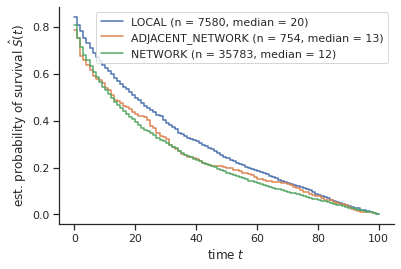

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44117.0,1.0,13.0,0.035616,-0.04,-0.04,-0.04


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,7580,20.0,0,100,29.010601,29.469129
ADJACENT_NETWORK,754,13.0,0,99,28.466297,24.942971
NETWORK,35783,12.0,0,100,27.170593,23.645698


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44117.0 &                1.0 &                   13.0 &                0.035616 & -0.04 &                        -0.04 &                         -0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg              &        &         &      &      &            &            \\
\midrule
LOCAL            &   7580 &    20.0 &    0 &  100 &  29.010601 &  29.469129 \\
ADJACENT\_NETWORK &    754 &    13.0 &    0 &   99 &  28.466297 &  24.942971 \\
NETWORK          &  35783 &    12.0 &    0 &  100 &  27.170593 &  23.645698 \\
\bottomrule
\end{tabular}



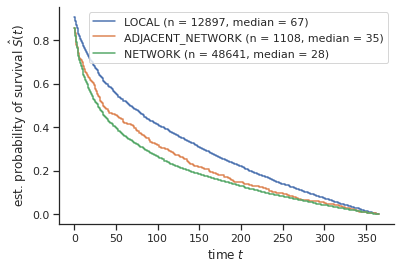

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62646.0,1.0,34.0,0.093151,-0.07,-0.07,-0.07


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,12897,67.0,0,365,106.193481,106.444832
ADJACENT_NETWORK,1108,35.0,0,365,97.537972,82.707581
NETWORK,48641,28.0,0,365,93.612581,72.591559


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62646.0 &                1.0 &                   34.0 &                0.093151 & -0.07 &                        -0.07 &                         -0.07 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &        mean \\
agg              &        &         &      &      &             &             \\
\midrule
LOCAL            &  12897 &    67.0 &    0 &  365 &  106.193481 &  106.444832 \\
ADJACENT\_NETWORK &   1108 &    35.0 &    0 &  365 &   97.537972 &   82.707581 \\
NETWORK          &  48641 &    28.0 &    0 &  365 &   93.612581 &   72.591559 \\
\bottomrule
\end{tabular}



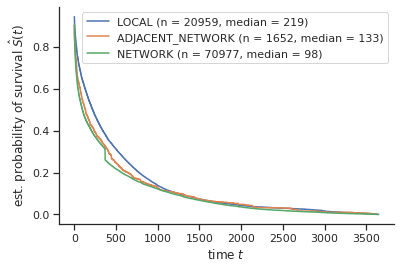

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93588.0,1.0,122.0,0.334247,-0.06,-0.06,-0.06


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,20959,219.0,0,3649,660.111859,473.996231
ADJACENT_NETWORK,1652,133.0,0,3633,658.937422,414.190073
NETWORK,70977,98.0,0,3646,606.983172,371.925215


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93588.0 &                1.0 &                  122.0 &                0.334247 & -0.06 &                        -0.06 &                         -0.06 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg              &        &         &      &       &             &             \\
\midrule
LOCAL            &  20959 &   219.0 &    0 &  3649 &  660.111859 &  473.996231 \\
ADJACENT\_NETWORK &   1652 &   133.0 &    0 &  3633 &  658.937422 &  414.190073 \\
NETWORK          &  70977 &    98.0 &    0 &  3646 &  606.983172 &  371.925215 \\
\bottomrule
\end{tabular}



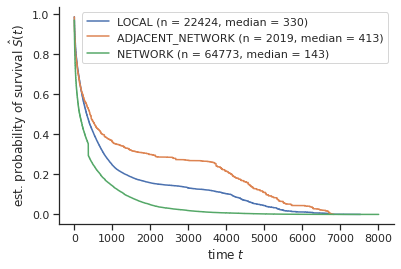

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89216.0,1.0,194.0,0.531507,-0.1,-0.1,-0.1


,count,median,min,max,std,mean
agg,,,,,,
LOCAL,22424,330.0,1,7538,1559.957587,1014.756689
ADJACENT_NETWORK,2019,413.0,1,6839,2096.721933,1621.982665
NETWORK,64773,143.0,1,8019,753.884939,453.797338


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89216.0 &                1.0 &                  194.0 &                0.531507 & -0.1 &                         -0.1 &                          -0.1 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &         mean \\
agg              &        &         &      &       &              &              \\
\midrule
LOCAL            &  22424 &   330.0 &    1 &  7538 &  1559.957587 &  1014.756689 \\
ADJACENT\_NETWORK &   2019 &   413.0 &    1 &  6839 &  2096.721933 &  1621.982665 \\
NETWORK          &  64773 &   143.0 &    1 &  8019 &   753.884939 &   453.797338 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [81]:
cvss_v = {'A':'-', 'AC':'-', 'AV':'-', 'Au':'-', 'C':'-', 'I':'-'}
# order by https://qualysguard.qg2.apps.qualys.com/qwebhelp/fo_portal/setup/cvss_vector_strings.htm
cvss_order = {
    'AV':['L','A','N'],
    'AC':['L','M','H'],
    
    'Au':['N','S','M'],

    'C':['N','P','C'],
    'A':['N','P','C'],
    'I':['N','P','C'],
}
for k in cvss_v.keys():
    key = 'cvssv_'+k
    #df_ext[key].fillna('-', inplace=True)
    print(df_ext[key].dropna().unique())
    if k in cvss_order:
        naive_compute(df_ext, key, "survival_analysis_", cvss_order[k])
    else:
        print("Error")
    #naive_compute(df_ext, key)

In [82]:
df['impact.availability'].unique()

['COMPLETE', 'NONE', 'PARTIAL', NaN]
Categories (3, object): ['NONE' < 'PARTIAL' < 'COMPLETE']

In [83]:
df['impact.confidentiality'].unique()

['PARTIAL', 'COMPLETE', 'NONE', NaN]
Categories (3, object): ['NONE' < 'PARTIAL' < 'COMPLETE']

In [84]:
df['impact.integrity'].unique()

['NONE', 'COMPLETE', 'PARTIAL', NaN]
Categories (3, object): ['NONE' < 'PARTIAL' < 'COMPLETE']

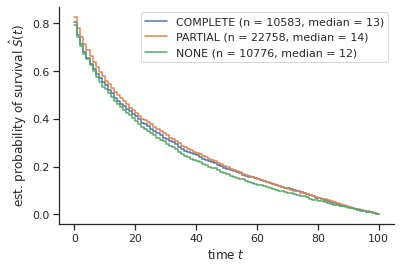

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44117.0,1.0,13.0,0.035616,0.02,0.02,0.02


,count,median,min,max,std,mean
agg,,,,,,
COMPLETE,10583,13.0,0,100,27.876823,24.553813
NONE,10776,12.0,0,100,26.728846,23.008259
PARTIAL,22758,14.0,0,100,27.848844,25.507821


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44117.0 &                1.0 &                   13.0 &                0.035616 &  0.02 &                         0.02 &                          0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg      &        &         &      &      &            &            \\
\midrule
COMPLETE &  10583 &    13.0 &    0 &  100 &  27.876823 &  24.553813 \\
NONE     &  10776 &    12.0 &    0 &  100 &  26.728846 &  23.008259 \\
PARTIAL  &  22758 &    14.0 &    0 &  100 &  27.848844 &  25.507821 \\
\bottomrule
\end{tabular}



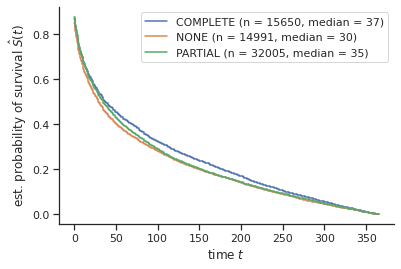

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62646.0,1.0,34.0,0.093151,-0.0,-0.0,-0.0


,count,median,min,max,std,mean
agg,,,,,,
COMPLETE,15650,37.0,0,365,100.990714,85.817444
NONE,14991,30.0,0,365,95.998127,75.625309
PARTIAL,32005,35.0,0,365,96.054793,78.695298


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62646.0 &                1.0 &                   34.0 &                0.093151 & -0.0 &                         -0.0 &                          -0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &       mean \\
agg      &        &         &      &      &             &            \\
\midrule
COMPLETE &  15650 &    37.0 &    0 &  365 &  100.990714 &  85.817444 \\
NONE     &  14991 &    30.0 &    0 &  365 &   95.998127 &  75.625309 \\
PARTIAL  &  32005 &    35.0 &    0 &  365 &   96.054793 &  78.695298 \\
\bottomrule
\end{tabular}



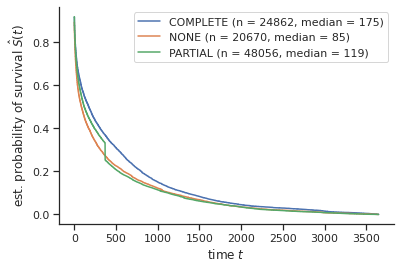

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93588.0,1.0,122.0,0.334247,-0.02,-0.02,-0.02


,count,median,min,max,std,mean
agg,,,,,,
COMPLETE,24862,175.0,0,3649,679.434733,467.239200
NONE,20670,85.0,0,3646,612.521844,365.771795
PARTIAL,48056,119.0,0,3646,590.603933,371.230668


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93588.0 &                1.0 &                  122.0 &                0.334247 & -0.02 &                        -0.02 &                         -0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg      &        &         &      &       &             &             \\
\midrule
COMPLETE &  24862 &   175.0 &    0 &  3649 &  679.434733 &  467.239200 \\
NONE     &  20670 &    85.0 &    0 &  3646 &  612.521844 &  365.771795 \\
PARTIAL  &  48056 &   119.0 &    0 &  3646 &  590.603933 &  371.230668 \\
\bottomrule
\end{tabular}



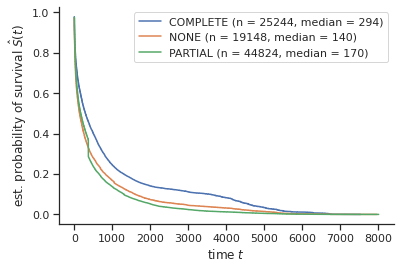

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89216.0,1.0,194.0,0.531507,-0.06,-0.06,-0.06


,count,median,min,max,std,mean
agg,,,,,,
COMPLETE,25244,294.0,1,7538,1458.700464,927.066828
NONE,19148,140.0,1,7969,1048.022599,571.153906
PARTIAL,44824,170.0,1,8019,809.730582,470.376852


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89216.0 &                1.0 &                  194.0 &                0.531507 & -0.06 &                        -0.06 &                         -0.06 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &        mean \\
agg      &        &         &      &       &              &             \\
\midrule
COMPLETE &  25244 &   294.0 &    1 &  7538 &  1458.700464 &  927.066828 \\
NONE     &  19148 &   140.0 &    1 &  7969 &  1048.022599 &  571.153906 \\
PARTIAL  &  44824 &   170.0 &    1 &  8019 &   809.730582 &  470.376852 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [85]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

languagesl = df['impact.availability'].unique()

languages = dict(zip(languagesl, range(len(languagesl))))

condition_names = dict(zip(range(len(languagesl)), languagesl))


def f_map(x):
    a = x['impact.availability']
    if pd.isnull(a):
        return None
    return languages[a]

compute_with_cutoff(df, f_map, condition_names, "most_used_language_impact_availability_survival_analysis")

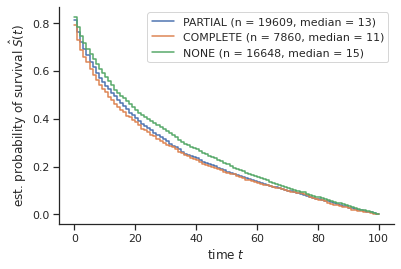

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44117.0,1.0,13.0,0.035616,0.02,0.02,0.02


,count,median,min,max,std,mean
agg,,,,,,
PARTIAL,19609,13.0,0,100,27.192460,23.943138
COMPLETE,7860,11.0,0,100,27.208806,22.959415
NONE,16648,15.0,0,100,28.181057,26.329589


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44117.0 &                1.0 &                   13.0 &                0.035616 &  0.02 &                         0.02 &                          0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg      &        &         &      &      &            &            \\
\midrule
PARTIAL  &  19609 &    13.0 &    0 &  100 &  27.192460 &  23.943138 \\
COMPLETE &   7860 &    11.0 &    0 &  100 &  27.208806 &  22.959415 \\
NONE     &  16648 &    15.0 &    0 &  100 &  28.181057 &  26.329589 \\
\bottomrule
\end{tabular}



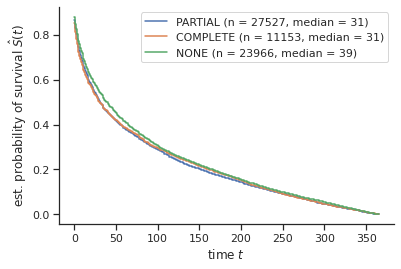

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62646.0,1.0,34.0,0.093151,0.02,0.02,0.02


,count,median,min,max,std,mean
agg,,,,,,
PARTIAL,27527,31.0,0,365,96.200049,77.271370
COMPLETE,11153,31.0,0,365,97.712090,78.585493
NONE,23966,39.0,0,365,98.440244,83.112409


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62646.0 &                1.0 &                   34.0 &                0.093151 &  0.02 &                         0.02 &                          0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg      &        &         &      &      &            &            \\
\midrule
PARTIAL  &  27527 &    31.0 &    0 &  365 &  96.200049 &  77.271370 \\
COMPLETE &  11153 &    31.0 &    0 &  365 &  97.712090 &  78.585493 \\
NONE     &  23966 &    39.0 &    0 &  365 &  98.440244 &  83.112409 \\
\bottomrule
\end{tabular}



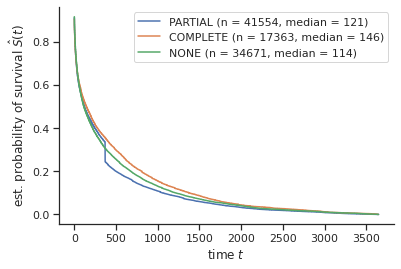

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93588.0,1.0,122.0,0.334247,0.01,0.01,0.01


,count,median,min,max,std,mean
agg,,,,,,
PARTIAL,41554,121.0,0,3649,584.340537,364.076046
COMPLETE,17363,146.0,0,3646,674.626787,455.636814
NONE,34671,114.0,0,3646,634.820835,403.127311


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93588.0 &                1.0 &                  122.0 &                0.334247 &  0.01 &                         0.01 &                          0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg      &        &         &      &       &             &             \\
\midrule
PARTIAL  &  41554 &   121.0 &    0 &  3649 &  584.340537 &  364.076046 \\
COMPLETE &  17363 &   146.0 &    0 &  3646 &  674.626787 &  455.636814 \\
NONE     &  34671 &   114.0 &    0 &  3646 &  634.820835 &  403.127311 \\
\bottomrule
\end{tabular}



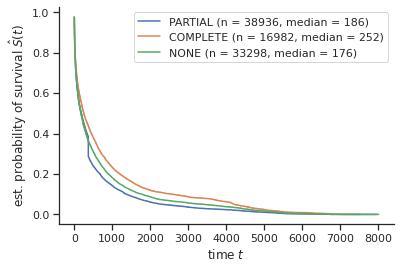

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89216.0,1.0,194.0,0.531507,0.02,0.02,0.02


,count,median,min,max,std,mean
agg,,,,,,
PARTIAL,38936,186.0,1,7969,941.404932,518.914115
COMPLETE,16982,252.0,1,7538,1325.244287,821.968084
NONE,33298,176.0,1,8019,1124.839576,638.488798


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89216.0 &                1.0 &                  194.0 &                0.531507 &  0.02 &                         0.02 &                          0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &        mean \\
agg      &        &         &      &       &              &             \\
\midrule
PARTIAL  &  38936 &   186.0 &    1 &  7969 &   941.404932 &  518.914115 \\
COMPLETE &  16982 &   252.0 &    1 &  7538 &  1325.244287 &  821.968084 \\
NONE     &  33298 &   176.0 &    1 &  8019 &  1124.839576 &  638.488798 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [86]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

languagesl = df['impact.confidentiality'].unique()

languages = dict(zip(languagesl, range(len(languagesl))))

condition_names = dict(zip(range(len(languagesl)), languagesl))


def f_map(x):
    a = x['impact.confidentiality']
    if pd.isnull(a):
        return None
    return languages[a]

compute_with_cutoff(df, f_map, condition_names, "most_used_language_impact_confidentiality_survival_analysis")

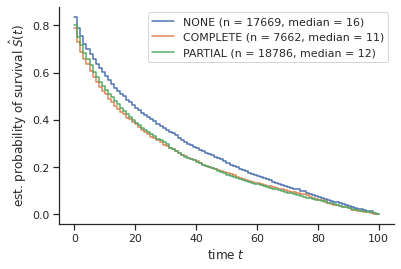

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44117.0,1.0,13.0,0.035616,-0.04,-0.04,-0.04


,count,median,min,max,std,mean
agg,,,,,,
NONE,17669,16.0,0,100,28.493787,27.112513
COMPLETE,7662,11.0,0,100,27.196788,22.826286
PARTIAL,18786,12.0,0,100,26.737237,23.120994


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44117.0 &                1.0 &                   13.0 &                0.035616 & -0.04 &                        -0.04 &                         -0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg      &        &         &      &      &            &            \\
\midrule
NONE     &  17669 &    16.0 &    0 &  100 &  28.493787 &  27.112513 \\
COMPLETE &   7662 &    11.0 &    0 &  100 &  27.196788 &  22.826286 \\
PARTIAL  &  18786 &    12.0 &    0 &  100 &  26.737237 &  23.120994 \\
\bottomrule
\end{tabular}



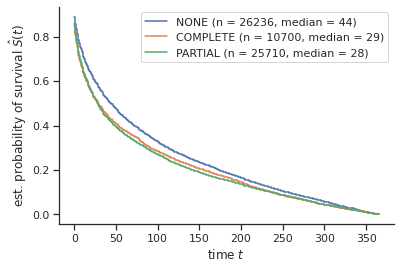

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62646.0,1.0,34.0,0.093151,-0.05,-0.05,-0.05


,count,median,min,max,std,mean
agg,,,,,,
NONE,26236,44.0,0,365,99.706459,87.322763
COMPLETE,10700,29.0,0,365,96.184603,76.092991
PARTIAL,25710,28.0,0,365,94.884877,73.519642


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62646.0 &                1.0 &                   34.0 &                0.093151 & -0.05 &                        -0.05 &                         -0.05 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg      &        &         &      &      &            &            \\
\midrule
NONE     &  26236 &    44.0 &    0 &  365 &  99.706459 &  87.322763 \\
COMPLETE &  10700 &    29.0 &    0 &  365 &  96.184603 &  76.092991 \\
PARTIAL  &  25710 &    28.0 &    0 &  365 &  94.884877 &  73.519642 \\
\bottomrule
\end{tabular}



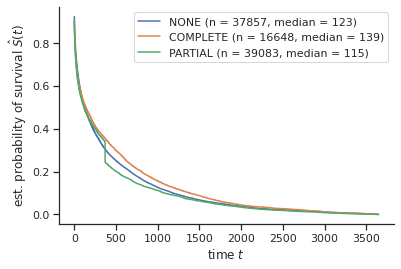

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93588.0,1.0,122.0,0.334247,-0.02,-0.02,-0.02


,count,median,min,max,std,mean
agg,,,,,,
NONE,37857,123.0,0,3649,628.058973,400.330111
COMPLETE,16648,139.0,0,3645,674.833727,454.331511
PARTIAL,39083,115.0,0,3646,589.067052,365.833150


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93588.0 &                1.0 &                  122.0 &                0.334247 & -0.02 &                        -0.02 &                         -0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg      &        &         &      &       &             &             \\
\midrule
NONE     &  37857 &   123.0 &    0 &  3649 &  628.058973 &  400.330111 \\
COMPLETE &  16648 &   139.0 &    0 &  3645 &  674.833727 &  454.331511 \\
PARTIAL  &  39083 &   115.0 &    0 &  3646 &  589.067052 &  365.833150 \\
\bottomrule
\end{tabular}



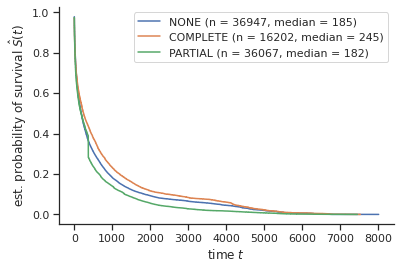

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89216.0,1.0,194.0,0.531507,-0.03,-0.03,-0.03


,count,median,min,max,std,mean
agg,,,,,,
NONE,36947,185.0,1,8019,1186.520846,668.828349
COMPLETE,16202,245.0,1,7538,1301.655074,806.937292
PARTIAL,36067,182.0,1,7458,862.417315,489.042698


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89216.0 &                1.0 &                  194.0 &                0.531507 & -0.03 &                        -0.03 &                         -0.03 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &        mean \\
agg      &        &         &      &       &              &             \\
\midrule
NONE     &  36947 &   185.0 &    1 &  8019 &  1186.520846 &  668.828349 \\
COMPLETE &  16202 &   245.0 &    1 &  7538 &  1301.655074 &  806.937292 \\
PARTIAL  &  36067 &   182.0 &    1 &  7458 &   862.417315 &  489.042698 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [87]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

languagesl = df['impact.integrity'].unique()

languages = dict(zip(languagesl, range(len(languagesl))))

condition_names = dict(zip(range(len(languagesl)), languagesl))


def f_map(x):
    a = x['impact.integrity']
    if pd.isnull(a):
        return None
    return languages[a]

compute_with_cutoff(df, f_map, condition_names, "most_used_language_impact_integrity_survival_analysis")

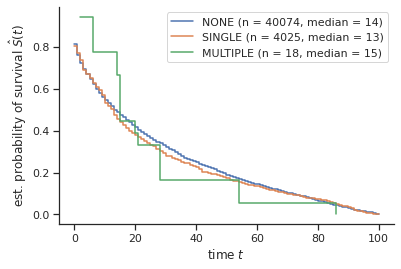

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44117.0,1.0,13.0,0.035616,-0.0,-0.0,-0.0


,count,median,min,max,std,mean
agg,,,,,,
NONE,40074,14.0,0,100,27.641936,24.787393
SINGLE,4025,13.0,0,100,27.231308,23.488199
MULTIPLE,18,15.0,2,86,21.276349,23.722222


/tmp/ipykernel_3842559/1068964389.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44117.0 &                1.0 &                   13.0 &                0.035616 & -0.0 &                         -0.0 &                          -0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg      &        &         &      &      &            &            \\
\midrule
NONE     &  40074 &    14.0 &    0 &  100 &  27.641936 &  24.787393 \\
SINGLE   &   4025 &    13.0 &    0 &  100 &  27.231308 &  23.488199 \\
MULTIPLE &     18 &    15.0 &    2 &   86 &  21.276349 &  23.722222 \\
\bottomrule
\end{tabular}



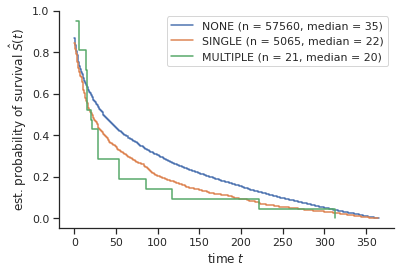

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62646.0,1.0,34.0,0.093151,-0.02,-0.02,-0.02


,count,median,min,max,std,mean
agg,,,,,,
NONE,57560,35.0,0,365,98.283091,81.451598
SINGLE,5065,22.0,0,364,83.967588,60.405331
MULTIPLE,21,20.0,2,313,78.417685,51.333333


/tmp/ipykernel_3842559/1068964389.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62646.0 &                1.0 &                   34.0 &                0.093151 & -0.02 &                        -0.02 &                         -0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg      &        &         &      &      &            &            \\
\midrule
NONE     &  57560 &    35.0 &    0 &  365 &  98.283091 &  81.451598 \\
SINGLE   &   5065 &    22.0 &    0 &  364 &  83.967588 &  60.405331 \\
MULTIPLE &     21 &    20.0 &    2 &  313 &  78.417685 &  51.333333 \\
\bottomrule
\end{tabular}



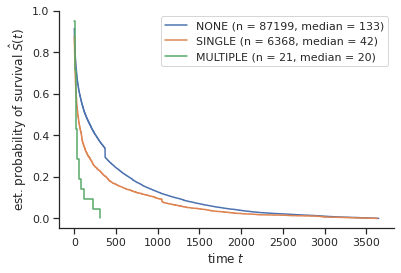

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93588.0,1.0,122.0,0.334247,-0.02,-0.02,-0.02


,count,median,min,max,std,mean
agg,,,,,,
NONE,87199,133.0,0,3649,626.059293,404.271574
SINGLE,6368,42.0,0,3633,545.113037,276.964510
MULTIPLE,21,20.0,2,313,78.417685,51.333333


/tmp/ipykernel_3842559/1068964389.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93588.0 &                1.0 &                  122.0 &                0.334247 & -0.02 &                        -0.02 &                         -0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg      &        &         &      &       &             &             \\
\midrule
NONE     &  87199 &   133.0 &    0 &  3649 &  626.059293 &  404.271574 \\
SINGLE   &   6368 &    42.0 &    0 &  3633 &  545.113037 &  276.964510 \\
MULTIPLE &     21 &    20.0 &    2 &   313 &   78.417685 &   51.333333 \\
\bottomrule
\end{tabular}



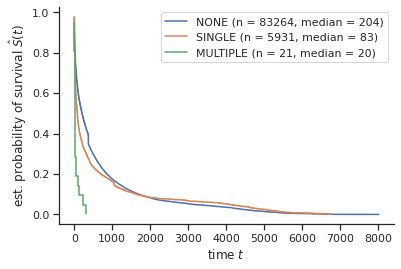

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89216.0,1.0,194.0,0.531507,-0.02,-0.02,-0.02


,count,median,min,max,std,mean
agg,,,,,,
NONE,83264,204.0,1,8019,1087.583043,623.654965
SINGLE,5931,83.0,1,6756,1236.078779,589.178385
MULTIPLE,21,20.0,2,313,78.417685,51.333333


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89216.0 &                1.0 &                  194.0 &                0.531507 & -0.02 &                        -0.02 &                         -0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &        mean \\
agg      &        &         &      &       &              &             \\
\midrule
NONE     &  83264 &   204.0 &    1 &  8019 &  1087.583043 &  623.654965 \\
SINGLE   &   5931 &    83.0 &    1 &  6756 &  1236.078779 &  589.178385 \\
MULTIPLE &     21 &    20.0 &    2 &   313 &    78.417685 &   51.333333 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3842559/1068964389.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [88]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
languagesl = df['access.authentication'].unique()

languages = dict(zip(languagesl, range(len(languagesl))))

condition_names = dict(zip(range(len(languagesl)), languagesl))

def f_map(x):
    a = x['access.authentication']
    if pd.isnull(a):
        return None
    return languages[a]

compute_with_cutoff(df, f_map, condition_names, "most_used_language_access_authentication_survival_analysis")